In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statannotations.Annotator import Annotator
from itertools import combinations

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
metadata = pd.read_csv('../../data/metadata_combined.txt', sep='\t', index_col=0)
metadata.head()

age_enrollment_study  collection_date  collection_timestamp  \
sample_name                                                                
14834.100328                    0             2021                  2021   
14834.100334                    0             2021                  2021   
14834.100707                    0             2021                  2021   
14834.100787                    1             2021                  2021   
14834.100797                    1             2021                  2021   

                 country     description  dna_extracted  elevation  \
sample_name                                                          
14834.100328  Bangladesh    infant stool           True         32   
14834.100334  Bangladesh    infant stool           True         32   
14834.100707  Bangladesh  maternal stool           True         32   
14834.100787  Bangladesh  maternal stool           True         32   
14834.100797  Bangladesh  maternal stool           True         32   

                       empo_1                        empo_2  \
sample_name                                                   
14834.100328  Host-associated  Host-associated (non-saline)   
14834.100334  Host-associated  Host-associated (non-saline)   
14834.100707  Host-associated  Host-associated (non-saline)   
14834.100787  Host-associated  Host-associated (non-saline)   
14834.100797  Host-associated  Host-associated (non-saline)   

                           empo_3  ... hmo_Secretor drink_water_safe  \
sample_name                        ...                                 
14834.100328  Animal (non-saline)  ...            1          nothing   
14834.100334  Animal (non-saline)  ...            0           filter   
14834.100707  Animal (non-saline)  ...            1          nothing   
14834.100787  Animal (non-saline)  ...            1          nothing   
14834.100797  Animal (non-saline)  ...            1          nothing   

             drink_water_safe_simplified sample_type_binary  \
sample_name                                                   
14834.100328                   Untreated             sample   
14834.100334                     Treated             sample   
14834.100707                   Untreated             sample   
14834.100787                   Untreated             sample   
14834.100797                   Untreated             sample   

             host_age_infant_cat hmo_Secretor_str  sample_type2  \
sample_name                                                       
14834.100328                 180         secretor  infant_feces   
14834.100334                 180   not a secretor  infant_feces   
14834.100707                 180         secretor   adult_feces   
14834.100787                 180         secretor   adult_feces   
14834.100797                 180         secretor   adult_feces   

                 delivery_bf-cat SourceSink             30d_cat  
sample_name                                                      
14834.100328  Vaginal_Partial BF       Sink  older than 30 days  
14834.100334  Vaginal_Partial BF       Sink  older than 30 days  
14834.100707         Vaginal_nan     Source  older than 30 days  
14834.100787         Vaginal_nan     Source  older than 30 days  
14834.100797         Vaginal_nan     Source  older than 30 days  

[5 rows x 76 columns]

In [4]:
def create_stacked_barplot(df, timepoint_col, sample_type_col, value_col):
    """
    Creates a stacked bar plot of the counts of different sample types at different timepoints.

    Args:
        df: The input Pandas DataFrame.
        timepoint_col: The name of the column containing timepoint information.
        sample_type_col: The name of the column containing sample type information.
        value_col: The name of the column containing the values (counts) for the stacked barplot.
    """
    # Group the DataFrame by timepoint and sample type and sum the values
    grouped_df = df.groupby([timepoint_col, sample_type_col])[value_col].sum().unstack().fillna(0)

    # Create the stacked bar plot
    grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))  # Adjust figure size as needed
    plt.xlabel(timepoint_col)
    plt.ylabel(value_col)
    plt.title(f'Stacked Bar Plot of {value_col} by {sample_type_col} at Different {timepoint_col}s')
    plt.legend(title=sample_type_col)
    plt.show()

In [5]:
micro_md = metadata[metadata.sample_type.isin(['feces', 'breast milk', 
                                                      'vaginal mucus', 'skin of arm', 
                                                      'tongue'])]
micro_md2 = micro_md[['host_age_infant_cat', 'sample_type', 'host_subject_id']].groupby(['host_age_infant_cat', 'sample_type',]).count().reset_index()
micro_md2.rename(columns={'host_subject_id':'sample_counts'}, inplace=True)
micro_md2.head()

host_age_infant_cat    sample_type  sample_counts
0                    0    breast milk             21
1                    0          feces             75
2                    0    skin of arm             54
3                    0         tongue             53
4                    0  vaginal mucus             50

In [6]:
micro_md3 = micro_md2.pivot(index='host_age_infant_cat',
                    columns='sample_type',
                    values='sample_counts')
micro_md3 = micro_md3[['feces','breast milk','skin of arm','tongue','vaginal mucus']].copy()
micro_md3.plot(kind='bar', stacked=True, figsize=(10, 6),
              color=['#008080', '#BE98C7', '#3D793B', '#6851A2', '#F69320'])
plt.title(f'Stacked Bar Plot of Sample Types at Different Timepoints')
plt.ylabel(f'Sample Counts')
plt.xlabel(f'Timepoint')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/sample_distribution_stackedbar2.svg'.format(adiv), dpi=150, bbox_inches='tight')
plt.show()

# Alpha Diversity

## Shannon - feces - rar 500K

In [10]:
im_feces_ssamp = pd.read_csv('../../data/Microbiome/each_body_site_faith-pd/shannon_feces_rar500K/alpha-diversity.tsv', 
                      sep='\t', index_col=0, dtype={0: object})

In [11]:
im_feces_shannon = pd.merge(metadata, im_feces_ssamp, left_index=True, right_index=True)

In [12]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'], 
                 y='shannon_entropy', x='host_age_infant_cat', 
                color='#008080')
g = sns.scatterplot(data=im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'], 
                    y='shannon_entropy', x='host_age_infant', alpha=0.5, s=100,
                color='#008080')
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_shannon_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

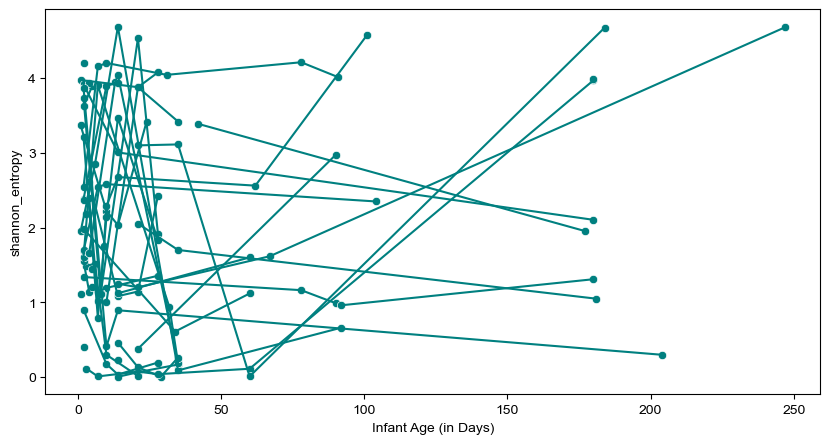

In [64]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'], 
                 y='shannon_entropy', x='host_age_infant', 
                 units='host_subject_id', estimator=None,
                color='#008080')
g = sns.scatterplot(data=im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'], 
                    y='shannon_entropy', x='host_age_infant',
                color='#008080')
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_shannon_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
data = im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'].copy()
data.dropna(subset=['shannon_entropy'], inplace=True) #need to drop nans
model = smf.mixedlm("shannon_entropy~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs', 'powell', 'cg'])
print("LME for Shannon alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Shannon alpha diversity for infant fecal samples over time
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shannon_entropy
No. Observations: 129     Method:             REML           
No. Groups:       44      Scale:              1.3442         
Min. group size:  1       Log-Likelihood:     -225.5544      
Max. group size:  6       Converged:          Yes            
Mean group size:  2.9                                        
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.861    0.183 10.178 0.000  1.503  2.220
host_age_infant     0.004    0.002  1.531 0.126 -0.001  0.008
host_subject_id Var 0.654    0.250                           



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [14]:
im_feces_shannon['cat30tp'] = im_feces_shannon['30d_cat']

In [15]:
data = im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'].copy()
data.dropna(subset=['shannon_entropy'], inplace=True) #need to drop nans
model = smf.mixedlm("shannon_entropy~C(cat30tp, Treatment(reference='30 days of age or less'))", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs', 'powell', 'cg'])
print("LME for Shannon alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Shannon alpha diversity for infant fecal samples over time
                                          Mixed Linear Model Regression Results
Model:                                 MixedLM                     Dependent Variable:                     shannon_entropy
No. Observations:                      129                         Method:                                 REML           
No. Groups:                            44                          Scale:                                  1.3740         
Min. group size:                       1                           Log-Likelihood:                         -221.8931      
Max. group size:                       6                           Converged:                              Yes            
Mean group size:                       2.9                                                                                
-------------------------------------------------------------------------------------------------------------------

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [17]:
data = im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'].copy()
data2 = data[data['host_age_infant']<=30].copy()
data2.dropna(subset=['shannon_entropy'], inplace=True) #need to drop nans
model = smf.mixedlm("shannon_entropy~host_age_infant", data2, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs', 'powell', 'cg'])
print("LME for Shannon alpha diversity for infant fecal samples - Early Timepoints only")
print(res.summary())

LME for Shannon alpha diversity for infant fecal samples - Early Timepoints only
            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: shannon_entropy
No. Observations:  93      Method:             REML           
No. Groups:        41      Scale:              0.9792         
Min. group size:   1       Log-Likelihood:     -155.8321      
Max. group size:   5       Converged:          Yes            
Mean group size:   2.3                                        
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            2.043    0.244  8.358 0.000  1.564  2.522
host_age_infant     -0.004    0.015 -0.244 0.807 -0.033  0.025
host_subject_id Var  0.910    0.420                           



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [18]:
df = im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'].copy()
dff = df[df['host_age_infant_cat'].isin([0,180])]
g = sns.boxplot(data=dff, 
                 y='shannon_entropy', x='host_age_infant_cat', order=[0, 180],
                color='#008080',
               fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
g = sns.stripplot(data=dff, 
                    y='shannon_entropy', x='host_age_infant_cat', order=[0, 180],
                color='#008080', s=10, linewidth=1, edgecolor='k', alpha=0.5)

pairs = [(0, 180)]
annot = Annotator(g, pairs, data=dff, 
                  x='host_age_infant_cat', y='shannon_entropy',
                 order=[0, 180],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_shannon_boxswarmplot_2tp.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.310e-01 U_stat=9.200e+01


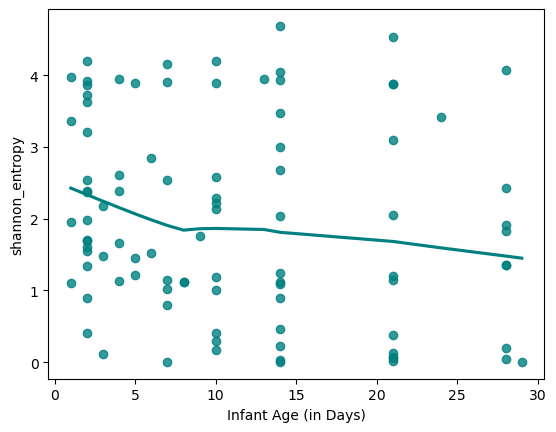

In [19]:
df = im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'].copy()
df2 = df[df['30d_cat']=='30 days of age or less'].copy()
g = sns.regplot(data=df2, 
                 y='shannon_entropy', x='host_age_infant', 
                color='#008080',
                lowess=True, )
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_shannon_regplot-lowess_less30.png', dpi=150, bbox_inches='tight')
plt.show()

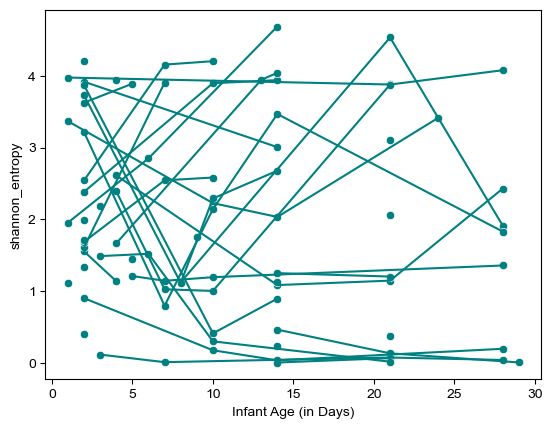

In [66]:
df = im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'].copy()
df2 = df[df['30d_cat']=='30 days of age or less'].copy()
g = sns.lineplot(data=df2, 
                 y='shannon_entropy', x='host_age_infant', units='host_subject_id', estimator=None,
                color='#008080',)
g = sns.scatterplot(data=df2, 
                 y='shannon_entropy', x='host_age_infant', units='host_subject_id', estimator=None,
                color='#008080',)
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_shannon_regplot-lowess_less30.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
data = im_feces_shannon[im_feces_shannon['sample_type2']=='infant_feces'].copy()
data2 = data[data['host_age_infant']<=30].copy()
data2.dropna(subset=['shannon_entropy'], inplace=True) #need to drop nans
model = smf.mixedlm("shannon_entropy~host_age_infant", data2, 
                        groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs', 'powell', 'cg'])
print("LME for Shannon alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Shannon alpha diversity for infant fecal samples over time
            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: shannon_entropy
No. Observations:  93      Method:             REML           
No. Groups:        41      Scale:              0.9792         
Min. group size:   1       Log-Likelihood:     -155.8321      
Max. group size:   5       Converged:          Yes            
Mean group size:   2.3                                        
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            2.043    0.244  8.358 0.000  1.564  2.522
host_age_infant     -0.004    0.015 -0.244 0.807 -0.033  0.025
host_subject_id Var  0.910    0.420                           



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


## Faith's PD

In [21]:
im_feces_fsamp = pd.read_csv('../../data/Microbiome/each_body_site_faith-pd/faith_feces_rar500K/alpha-diversity.tsv', 
                      sep='\t', index_col=0, dtype={0: object})
im_feces_fsamp.index = im_feces_fsamp.index.astype(str)
i_skin_fsamp = pd.read_csv('../../data/Microbiome/each_body_site_faith-pd/faith_infant_skin_rar300K/alpha-diversity.tsv', 
                      sep='\t', index_col=0, dtype={0: object})
i_skin_fsamp.index = i_skin_fsamp.index.astype(str)
i_tongue_fsamp = pd.read_csv('../../data/Microbiome/each_body_site_faith-pd/faith_infant_tongue_rar20K/alpha-diversity.tsv', 
                      sep='\t', index_col=0, dtype={0: object})
i_tongue_fsamp.index = i_tongue_fsamp.index.astype(str)
m_milk_fsamp = pd.read_csv('../../data/Microbiome/each_body_site_faith-pd/faith_adult_milk_rar750/alpha-diversity.tsv', 
                      sep='\t', index_col=0, dtype={0: object})
m_milk_fsamp.index = m_milk_fsamp.index.astype(str)
m_vaginal_fsamp = pd.read_csv('../../data/Microbiome/each_body_site_faith-pd/faith_adult_vagina_rar600/alpha-diversity.tsv', 
                      sep='\t', index_col=0, dtype={0: object})
m_vaginal_fsamp.index = m_vaginal_fsamp.index.astype(str)

In [22]:
im_feces_faith = pd.merge(metadata, im_feces_fsamp, left_index=True, right_index=True)
i_skin_faith = pd.merge(metadata, i_skin_fsamp, left_index=True, right_index=True)
i_tongue_faith = pd.merge(metadata, i_tongue_fsamp, left_index=True, right_index=True)
m_milk_faith = pd.merge(metadata, m_milk_fsamp, left_index=True, right_index=True)
m_vaginal_faith = pd.merge(metadata, m_vaginal_fsamp, left_index=True, right_index=True)

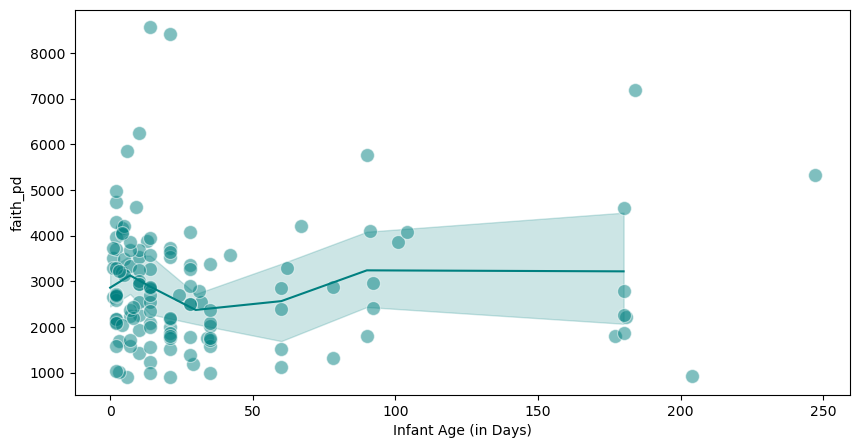

In [23]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                 y='faith_pd', x='host_age_infant_cat', 
                color='#008080')
g = sns.scatterplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                    y='faith_pd', x='host_age_infant', alpha=0.5, s=100,
                color='#008080')
#plt.xlim(-2,190)
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
data = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1" )
res = model.fit(method=['lbfgs', 'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples over time
                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     faith_pd    
No. Observations:     129         Method:                 REML        
No. Groups:           44          Scale:                  1502674.0030
Min. group size:      1           Log-Likelihood:         -1102.6823  
Max. group size:      6           Converged:              Yes         
Mean group size:      2.9                                             
----------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             2793.827  165.753 16.855 0.000 2468.958 3118.696
host_age_infant          2.543    2.370  1.073 0.283   -2.103    7.189
host_subject_id Var 349926.142  173.200                               



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


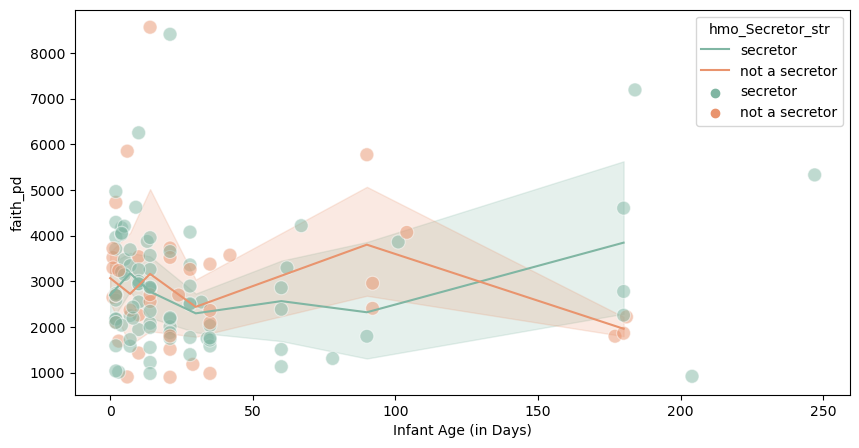

In [25]:
plt.figure(figsize=(10, 5))
ifeces_faith = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
g = sns.lineplot(data=ifeces_faith[ifeces_faith['hmo_Secretor_str']!='unknown'], 
                 y='faith_pd', x='host_age_infant_cat', 
                 hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'],
                   palette=['#80B6A3', '#E9946E'])
g = sns.scatterplot(data=ifeces_faith[ifeces_faith['hmo_Secretor_str']!='unknown'], 
                    y='faith_pd', x='host_age_infant', 
                    hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'],
                   alpha=0.5, s=100, palette=['#80B6A3', '#E9946E'])

plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_secretor_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
im_feces_faith['cat30tp'] = im_feces_faith['30d_cat']

In [27]:
im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].to_csv('../../data/Microbiome/each_body_site_faith-pd/faith_feces_rar500K/rformat_infant_feces.csv')

In [28]:
data = ifeces_faith.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant*fp_long_bin*mode_delivery", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples over time
                                       Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    faith_pd    
No. Observations:                    129                        Method:                                REML        
No. Groups:                          44                         Scale:                                 1497209.8545
Min. group size:                     1                          Log-Likelihood:                        -1069.1967  
Max. group size:                     6                          Converged:                             Yes         
Mean group size:                     2.9                                                                           
-------------------------------------------------------------------------------------------------------------------
                                           

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [29]:
data = ifeces_faith[ifeces_faith['hmo_Secretor_str']!='unknown'].copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant*hmo_Secretor_str", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples over time
                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             faith_pd    
No. Observations:               123                 Method:                         REML        
No. Groups:                     43                  Scale:                          1538676.5142
Min. group size:                1                   Log-Likelihood:                 -1042.7754  
Max. group size:                6                   Converged:                      Yes         
Mean group size:                2.9                                                             
------------------------------------------------------------------------------------------------
                                               Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------------------------

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [30]:
conditions = [
    ifeces_faith['host_age_infant'] <= 5,
    (ifeces_faith['host_age_infant'] >= 6) & (ifeces_faith['host_age_infant'] <= 14),
    ifeces_faith['host_age_infant'] > 14
]

choices = ['colostrum', 'transitional', 'mature']

ifeces_faith['hmo_time_group'] = np.select(conditions, choices, default='Unknown') 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

transitional_secretor vs. transitional_not a secretor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.000e+00 U_stat=1.260e+02
colostrum_secretor vs. colostrum_not a secretor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.826e-01 U_stat=9.800e+01
mature_secretor vs. mature_not a secretor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.233e-01 U_stat=3.440e+02


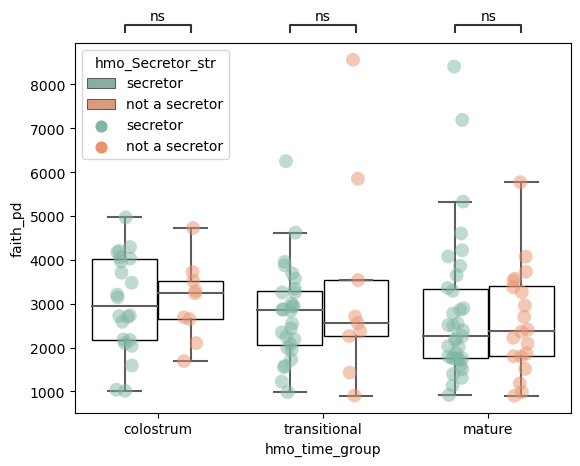

In [31]:
ax = sns.boxplot(data=ifeces_faith, y='faith_pd', x='hmo_time_group', order=['colostrum', 'transitional', 'mature'],
                 hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'], palette=['#80B6A3', '#E9946E'],
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=ifeces_faith, y='faith_pd', x='hmo_time_group',order=['colostrum', 'transitional', 'mature'],
                   hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'], palette=['#80B6A3', '#E9946E'],
                  size=10, alpha=0.5, dodge=True)

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [((tp,'secretor'), (tp, 'not a secretor')) for tp in ifeces_faith['hmo_time_group'].unique()]
annot = Annotator(ax, pairs, data=ifeces_faith, y='faith_pd', x='hmo_time_group', order=['colostrum', 'transitional', 'mature'],
                 hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                     verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_faith_secretor_hmo-tp_boxplot.svg', dpi=150, bbox_inches='tight')
plt.show()

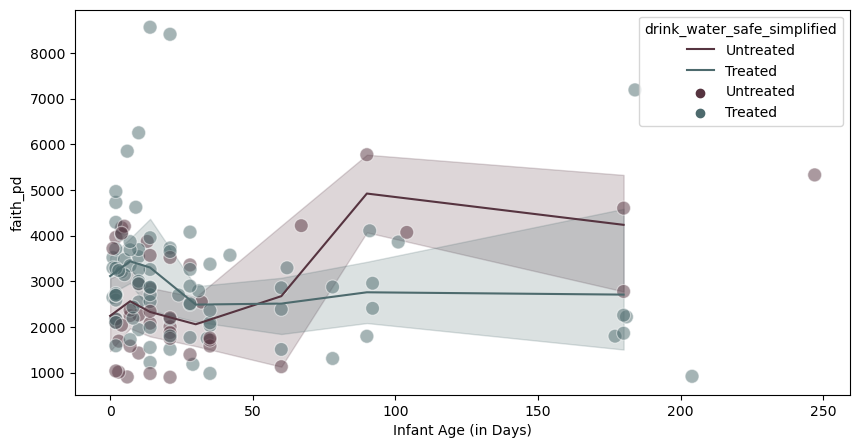

In [32]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                 y='faith_pd', x='host_age_infant_cat', 
                 hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'],
                   palette=['#563440', '#4D6A6D'])
g = sns.scatterplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                    y='faith_pd', x='host_age_infant', 
                    hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'],
                   alpha=0.5, s=100, palette=['#563440', '#4D6A6D'])

plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_water_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
data = ifeces_faith.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant*drink_water_safe_simplified", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples over time
                                   Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 faith_pd    
No. Observations:                   129                     Method:                             REML        
No. Groups:                         44                      Scale:                              1415879.0162
Min. group size:                    1                       Log-Likelihood:                     -1088.2391  
Max. group size:                    6                       Converged:                          Yes         
Mean group size:                    2.9                                                                     
------------------------------------------------------------------------------------------------------------
                                                           Coef.    Std.Err.   z    P>|z|   [0.0

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [34]:
im_feces_faith['30d_cat'].unique()

array(['older than 30 days', '30 days of age or less'], dtype=object)

In [35]:
plt.figure(figsize=(10, 5))
g = sns.boxplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                 y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                 hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'],
                   palette=['#563440', '#4D6A6D'], boxprops=dict(alpha=0.6))
g = sns.stripplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                    y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                    hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'],
                   alpha=0.5, s=10, palette=['#563440', '#4D6A6D'], dodge=True)

pairs = [(('30 days of age or less','Untreated'), ('30 days of age or less','Treated')),
        (('older than 30 days','Untreated'), ('older than 30 days','Treated'))]
annot = Annotator(g, pairs, data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                 y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                 hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'])
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_water_boxstripplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

older than 30 days_Untreated vs. older than 30 days_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.719e-01 U_stat=1.640e+02
30 days of age or less_Untreated vs. 30 days of age or less_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.168e-03 U_stat=6.430e+02


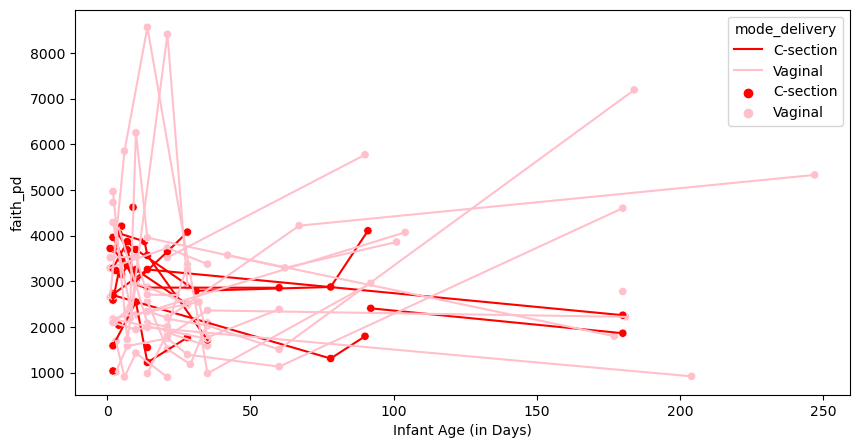

In [36]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                 y='faith_pd', x='host_age_infant', hue='mode_delivery',
                 units='host_subject_id', estimator=None,
                palette=['red', 'pink'])
g = sns.scatterplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                    y='faith_pd', x='host_age_infant', hue='mode_delivery',
                palette=['red', 'pink'])
#plt.xlim(-2,190)
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_scatterlineplot_indv_dmode.svg', dpi=150, bbox_inches='tight')
plt.show()

In [37]:
data = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant*mode_delivery", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples over time
                           Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            faith_pd    
No. Observations:             129                Method:                        REML        
No. Groups:                   44                 Scale:                         1455520.1820
Min. group size:              1                  Log-Likelihood:                -1091.0557  
Max. group size:              6                  Converged:                     Yes         
Mean group size:              2.9                                                           
--------------------------------------------------------------------------------------------
                                           Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------------------------
Intercept                     

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


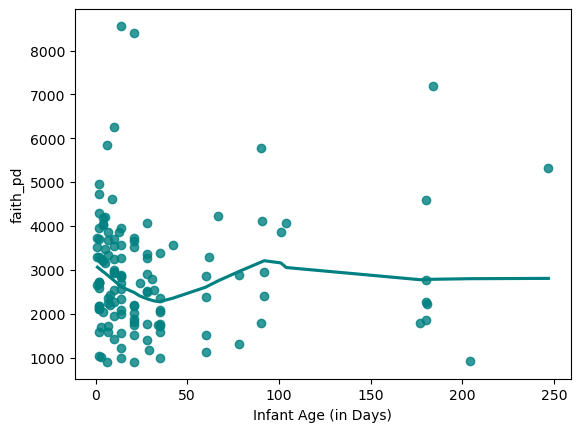

In [38]:
df = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
g = sns.regplot(data=df, 
                 y='faith_pd', x='host_age_infant', 
                color='#008080',
                lowess=True, )
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_regplot-lowess_less30.png', dpi=150, bbox_inches='tight')
plt.show()

In [39]:
data = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples over time
                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     faith_pd    
No. Observations:     129         Method:                 REML        
No. Groups:           44          Scale:                  1502674.0030
Min. group size:      1           Log-Likelihood:         -1102.6823  
Max. group size:      6           Converged:              Yes         
Mean group size:      2.9                                             
----------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             2793.827  165.753 16.855 0.000 2468.958 3118.696
host_age_infant          2.543    2.370  1.073 0.283   -2.103    7.189
host_subject_id Var 349926.142  173.200                               



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [40]:
data = ifeces_faith.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples over time
                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     faith_pd    
No. Observations:     129         Method:                 REML        
No. Groups:           44          Scale:                  1502674.0030
Min. group size:      1           Log-Likelihood:         -1102.6823  
Max. group size:      6           Converged:              Yes         
Mean group size:      2.9                                             
----------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             2793.827  165.753 16.855 0.000 2468.958 3118.696
host_age_infant          2.543    2.370  1.073 0.283   -2.103    7.189
host_subject_id Var 349926.142  173.200                               



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [41]:
dfx = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces']
dfx[dfx['host_age_infant_cat']==180].host_subject_id.nunique()

9

In [42]:
dfx.host_subject_id.nunique()

44

In [43]:
dfx.host_subject_id.value_counts()

111961    6
102541    6
114381    6
117751    5
123471    5
111871    5
106811    4
104281    4
105211    4
114941    4
114551    4
106841    4
114341    4
101631    4
102911    4
115001    4
123231    4
117051    4
107341    3
113391    3
100771    3
119591    3
120851    3
102861    3
121791    3
102511    3
103951    2
108361    2
110401    2
119351    2
101371    2
115471    2
104361    1
104551    1
106901    1
122581    1
120381    1
114591    1
115451    1
107271    1
103141    1
112151    1
101061    1
113651    1
Name: host_subject_id, dtype: int64

In [44]:
mask = dfx.host_subject_id.value_counts()>=3
dfy = dfx[dfx.host_subject_id.isin(mask.index)]
dfy.head()

age_enrollment_study  collection_date  collection_timestamp  \
14834.104557                    1             2021                  2021   
14834.104580                    1             2021                  2021   
14834.133390                    1             2022                  2022   
14834.145477                    1             2022                  2022   
14834.23149                     1             2021                  2021   

                 country   description  dna_extracted  elevation  \
14834.104557  Bangladesh  infant stool           True         32   
14834.104580  Bangladesh  infant stool           True         32   
14834.133390  Bangladesh  infant stool           True         32   
14834.145477  Bangladesh  infant stool           True         32   
14834.23149   Bangladesh  infant stool           True         32   

                       empo_1                        empo_2  \
14834.104557  Host-associated  Host-associated (non-saline)   
14834.104580  Host-associated  Host-associated (non-saline)   
14834.133390  Host-associated  Host-associated (non-saline)   
14834.145477  Host-associated  Host-associated (non-saline)   
14834.23149   Host-associated  Host-associated (non-saline)   

                           empo_3  ... drink_water_safe_simplified  \
14834.104557  Animal (non-saline)  ...                     Treated   
14834.104580  Animal (non-saline)  ...                     Treated   
14834.133390  Animal (non-saline)  ...                     Treated   
14834.145477  Animal (non-saline)  ...                   Untreated   
14834.23149   Animal (non-saline)  ...                     Treated   

             sample_type_binary host_age_infant_cat hmo_Secretor_str  \
14834.104557             sample                  90         secretor   
14834.104580             sample                  90         secretor   
14834.133390             sample                 180         secretor   
14834.145477             sample                 180         secretor   
14834.23149              sample                   0   not a secretor   

              sample_type2     delivery_bf-cat SourceSink  \
14834.104557  infant_feces       C-section_EBF       Sink   
14834.104580  infant_feces  Vaginal_Partial BF       Sink   
14834.133390  infant_feces  Vaginal_Partial BF       Sink   
14834.145477  infant_feces  Vaginal_Partial BF       Sink   
14834.23149   infant_feces         Vaginal_EBF       Sink   

                             30d_cat     faith_pd                 cat30tp  
14834.104557      older than 30 days  1795.637193      older than 30 days  
14834.104580      older than 30 days  3859.722350      older than 30 days  
14834.133390      older than 30 days   918.925930      older than 30 days  
14834.145477      older than 30 days  5328.441475      older than 30 days  
14834.23149   30 days of age or less  2648.506917  30 days of age or less  

[5 rows x 78 columns]

In [45]:
plt.figure(figsize=(15, 5))
g = sns.lineplot(data=dfy, 
                 y='faith_pd', x='host_age_infant', hue='mode_delivery',
                 units='host_subject_id', estimator=None,
                palette=['red', 'hotpink'])
g = sns.scatterplot(data=dfy, 
                    y='faith_pd', x='host_age_infant', hue='mode_delivery',
                palette=['red', 'hotpink'])
#plt.xlim(-2,190)
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_scatterlineplot_indv_dmode.svg', dpi=150, bbox_inches='tight')
plt.show()

In [46]:
data = dfy.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant*mode_delivery", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for infant fecal samples (with more than 3 longitudinal samples) over time")
print(res.summary())

LME for Faith PD alpha diversity for infant fecal samples (with more than 3 longitudinal samples) over time
                           Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            faith_pd    
No. Observations:             129                Method:                        REML        
No. Groups:                   44                 Scale:                         1455520.1820
Min. group size:              1                  Log-Likelihood:                -1091.0557  
Max. group size:              6                  Converged:                     Yes         
Mean group size:              2.9                                                           
--------------------------------------------------------------------------------------------
                                           Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------------------

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


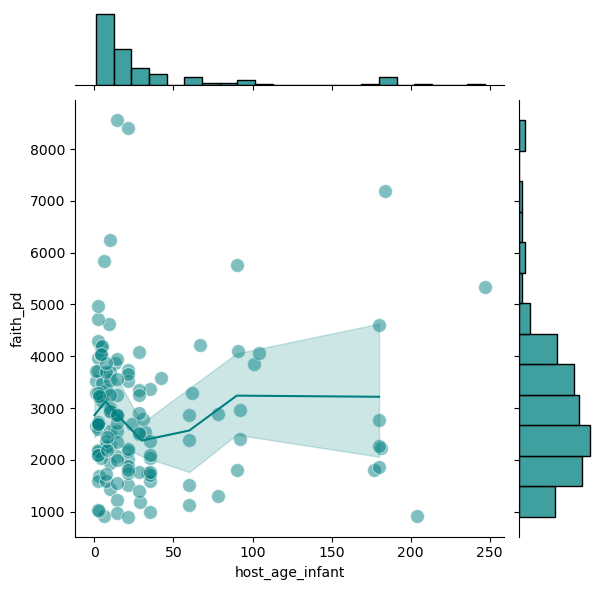

In [47]:

g = sns.jointplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], kind='scatter',
                  y='faith_pd', x='host_age_infant', color='#008080', s=100, alpha=0.5)

sns.lineplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'],
             y='faith_pd', x='host_age_infant_cat',
             color='#008080',  
             ax=g.ax_joint)
#g.ax_joint.set_xscale('log')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_faith_jointplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [48]:
data = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
data2 = data[data['30d_cat']=='30 days of age or less'].copy()
data2.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data2, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for faith alpha diversity for infant fecal samples 30 days of age or less")
print(res.summary())

LME for faith alpha diversity for infant fecal samples 30 days of age or less
                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     faith_pd    
No. Observations:     93          Method:                 REML        
No. Groups:           41          Scale:                  1167291.6696
Min. group size:      1           Log-Likelihood:         -786.2202   
Max. group size:      5           Converged:              Yes         
Mean group size:      2.3                                             
----------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             3007.642  236.029 12.743 0.000 2545.033 3470.250
host_age_infant         -8.430   14.987 -0.562 0.574  -37.804   20.944
host_subject_id Var 625499.219  287.852                               



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


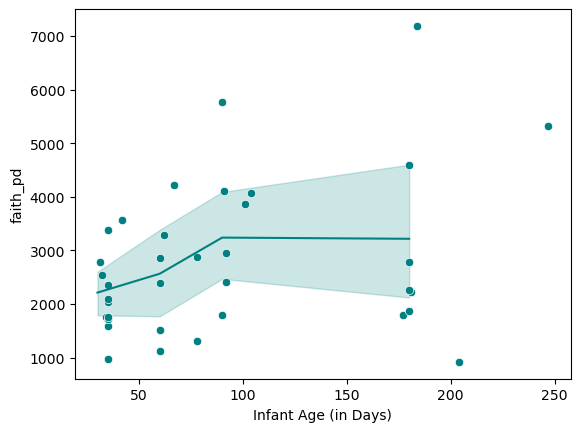

In [49]:
df = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
df2 = df[df['30d_cat']=='older than 30 days'].copy()
g = sns.lineplot(data=df2, 
                 y='faith_pd', x='host_age_infant_cat', 
                color='#008080')
g = sns.scatterplot(data=df2, 
                    y='faith_pd', x='host_age_infant', 
                color='#008080')
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_scatterlineplot_greater30.svg', dpi=150, bbox_inches='tight')
plt.show()

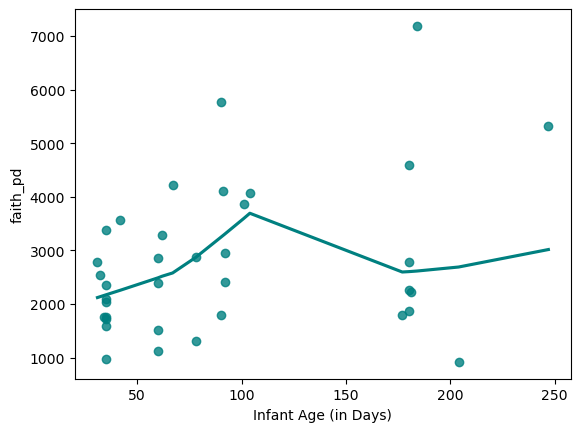

In [50]:
df = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
df2 = df[df['30d_cat']=='older than 30 days'].copy()
g = sns.regplot(data=df2, 
                 y='faith_pd', x='host_age_infant', 
                color='#008080',
                lowess=True,)
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/infant_feces_faith_regplot-lowess_more30.png', dpi=150, bbox_inches='tight')
plt.show()

In [51]:
data = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
data2 = data[data['30d_cat']=='older than 30 days'].copy()
data2.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data2, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for faith alpha diversity for infant fecal samples older than 30 days")
print(res.summary())

LME for faith alpha diversity for infant fecal samples older than 30 days
               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    faith_pd    
No. Observations:    36         Method:                REML        
No. Groups:          22         Scale:                 1821419.2943
Min. group size:     1          Log-Likelihood:        -301.0051   
Max. group size:     3          Converged:             Yes         
Mean group size:     1.6                                           
-------------------------------------------------------------------
                     Coef.   Std.Err.   z   P>|z|  [0.025   0.975] 
-------------------------------------------------------------------
Intercept           2118.588  414.355 5.113 0.000 1306.468 2930.709
host_age_infant        7.169    3.684 1.946 0.052   -0.052   14.390
host_subject_id Var    0.004  427.476                              



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

30 days of age or less vs. older than 30 days: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.053e-01 U_stat=1.833e+03


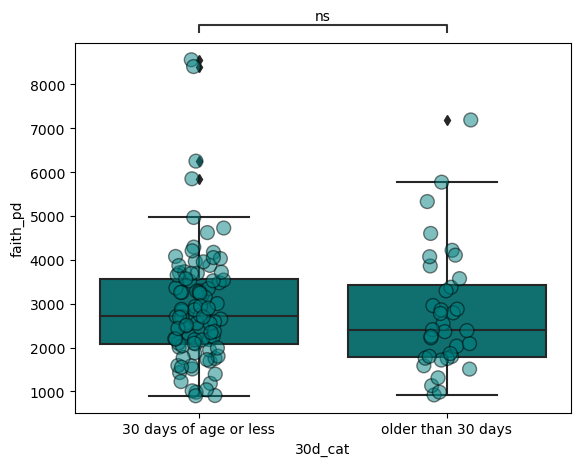

In [52]:
g = sns.boxplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                 y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                palette=['#008080', '#008080',])
g = sns.stripplot(data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                    y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                palette=['#008080', '#008080',], s=10, linewidth=1, edgecolor='k', alpha=0.5)

pairs = [('older than 30 days', '30 days of age or less')]
annot = Annotator(g, pairs, data=im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'], 
                  x='30d_cat', y='faith_pd',
                 order=['30 days of age or less', 'older than 30 days'],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_faith_boxswarmplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.000e+00 U_stat=1.080e+02


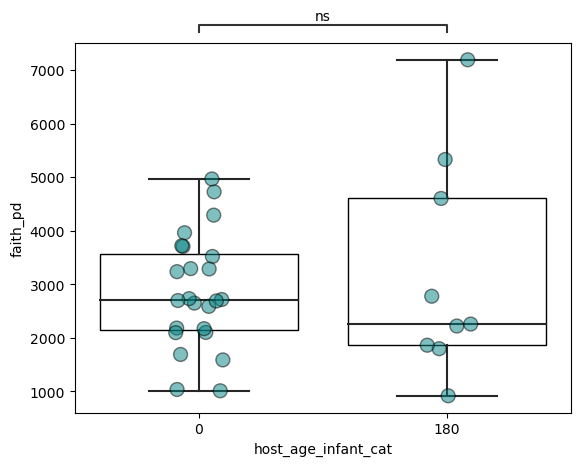

In [53]:
df = im_feces_faith[im_feces_faith['sample_type2']=='infant_feces'].copy()
dff = df[df['host_age_infant_cat'].isin([0,180])]
g = sns.boxplot(data=dff, 
                 y='faith_pd', x='host_age_infant_cat', order=[0, 180],
                color='#008080',
               fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
g = sns.stripplot(data=dff, 
                    y='faith_pd', x='host_age_infant_cat', order=[0, 180],
                color='#008080', s=10, linewidth=1, edgecolor='k', alpha=0.5)

pairs = [(0, 180)]
annot = Annotator(g, pairs, data=dff, 
                  x='host_age_infant_cat', y='faith_pd',
                 order=[0, 180],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_faith_boxswarmplot_2tp.svg', dpi=150, bbox_inches='tight')
plt.show()

#### Adult Feces

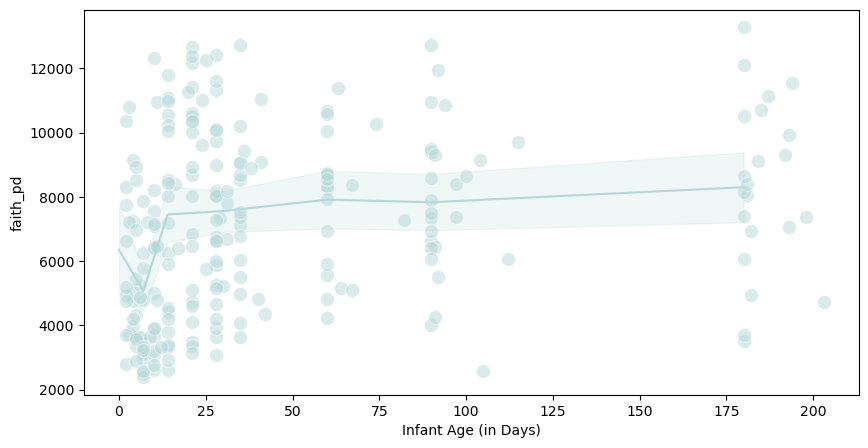

In [54]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'], 
                 y='faith_pd', x='host_age_infant_cat', 
                color='#B4D8D8')
g = sns.scatterplot(data=im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'], 
                    y='faith_pd', x='host_age_infant', alpha=0.5, s=100,
                color='#B4D8D8')
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/adult_feces_faith_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

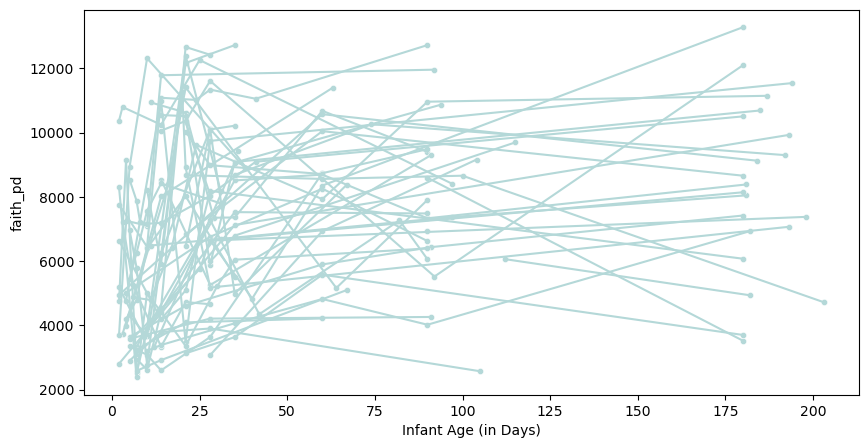

In [55]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'], 
                 y='faith_pd', x='host_age_infant', units='host_subject_id', estimator=None,
                color='#B4D8D8')
g = sns.scatterplot(data=im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'], 
                    y='faith_pd', x='host_age_infant', s=20,
                color='#B4D8D8')
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/adult_feces_faith_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [56]:
dfx = im_feces_faith[im_feces_faith['sample_type2']=='adult_feces']
dfx[dfx['host_age_infant_cat']==180].host_subject_id.nunique()

22

In [57]:
dfx.host_subject_id.nunique()

54

In [58]:
dfx.host_subject_id.value_counts()

104370    7
106900    7
114340    7
104550    7
121790    7
112150    7
114940    6
103950    6
114380    6
108360    6
106810    5
110900    5
101060    5
120850    5
106840    5
101630    5
103140    5
107270    5
111870    5
119350    5
123230    5
113390    5
102510    5
117750    5
100770    5
114130    4
111960    4
105710    4
115470    4
114590    4
102540    4
123470    4
115000    4
117050    4
104360    3
102680    3
122580    3
102860    3
120380    3
100580    3
111120    3
122810    3
114550    3
101370    3
103740    3
107340    3
113650    3
104280    3
111990    2
115450    2
102910    2
102280    2
119590    1
110400    1
Name: host_subject_id, dtype: int64

In [59]:
g = sns.jointplot(data=im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'], kind='scatter',
                  y='faith_pd', x='host_age_infant', color='#B4D8D8', s=100, alpha=0.5)

sns.lineplot(data=im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'],
             y='faith_pd', x='host_age_infant_cat',
             color='#B4D8D8',  
             ax=g.ax_joint) 

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_feces_faith_jointplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [60]:
data = im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'].copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for adult fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for adult fecal samples over time
                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     faith_pd    
No. Observations:      229         Method:                 REML        
No. Groups:            54          Scale:                  4831833.4313
Min. group size:       1           Log-Likelihood:         -2107.7648  
Max. group size:       7           Converged:              Yes         
Mean group size:       4.2                                             
-----------------------------------------------------------------------
                       Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              6397.556  302.073 21.179 0.000 5805.505 6989.608
host_age_infant          14.810    3.006  4.927 0.000    8.919   20.702
host_subject_id Var 2451666.623  363.306                               



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [61]:
df = im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'].copy()
df2 = df[df['30d_cat']=='30 days of age or less'].copy()
g = sns.lineplot(data=df2, 
                 y='faith_pd', x='host_age_infant_cat', 
                color='#B4D8D8')
g = sns.scatterplot(data=df2, 
                    y='faith_pd', x='host_age_infant', 
                color='#B4D8D8')
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/adult_feces_faith_L30_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [62]:
data = im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'].copy()
data2 = data[data['30d_cat']=='30 days of age or less'].copy()
data2.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data2, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for faith alpha diversity for adult fecal samples, less than 30 days postpartum")
print(res.summary())

LME for faith alpha diversity for adult fecal samples, less than 30 days postpartum
                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     faith_pd    
No. Observations:      136         Method:                 REML        
No. Groups:            48          Scale:                  4739697.5889
Min. group size:       1           Log-Likelihood:         -1249.7945  
Max. group size:       6           Converged:              Yes         
Mean group size:       2.8                                             
-----------------------------------------------------------------------
                       Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              4979.202  475.532 10.471 0.000 4047.176 5911.229
host_age_infant          98.243   23.388  4.201 0.000   52.402  144.083
host_subject_id Var 2977360.043  548.919                             

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [65]:
df = im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'].copy()
df2 = df[df['30d_cat']=='30 days of age or less'].copy()
g = sns.lineplot(data=df2, 
                 y='faith_pd', x='host_age_infant_cat', hue='mode_delivery',
                palette=['#B4D8D8', 'grey',])
g = sns.scatterplot(data=df2, 
                    y='faith_pd', x='host_age_infant', hue='mode_delivery',
                palette=['#B4D8D8', 'grey',])
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/adult_feces_faith_L30-dmode_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()
#bimodal not explained by delivery mode, secretor status, water treatment, 

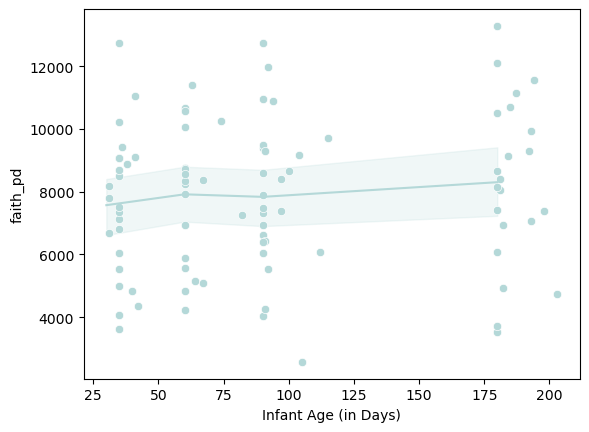

In [66]:
df = im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'].copy()
df2 = df[df['30d_cat']=='older than 30 days'].copy()
g = sns.lineplot(data=df2, 
                 y='faith_pd', x='host_age_infant_cat', 
                color='#B4D8D8')
g = sns.scatterplot(data=df2, 
                    y='faith_pd', x='host_age_infant', 
                color='#B4D8D8')
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/adult_feces_faith_G30_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [67]:
data = im_feces_faith[im_feces_faith['sample_type2']=='adult_feces'].copy()
data2 = data[data['30d_cat']=='older than 30 days'].copy()
data2.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data2, 
                        groups="host_subject_id", re_formula="1" )
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for faith alpha diversity for adult fecal samples, more than 30 days postpartum")
print(res.summary())

LME for faith alpha diversity for adult fecal samples, more than 30 days postpartum
                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     faith_pd    
No. Observations:      93          Method:                 REML        
No. Groups:            51          Scale:                  3205387.4503
Min. group size:       1           Log-Likelihood:         -840.2111   
Max. group size:       4           Converged:              Yes         
Mean group size:       1.8                                             
-----------------------------------------------------------------------
                       Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              7392.104  456.777 16.183 0.000 6496.838 8287.371
host_age_infant           6.084    3.774  1.612 0.107   -1.313   13.482
host_subject_id Var 2466751.664  761.850                             

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


#### Both

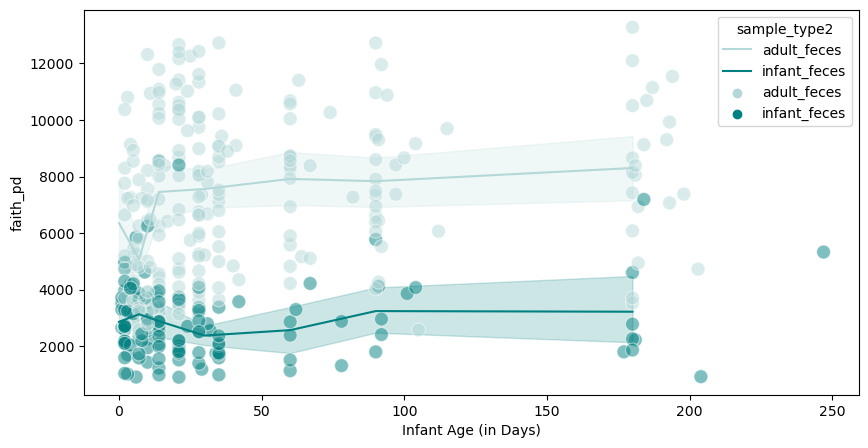

In [68]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=im_feces_faith, 
                 y='faith_pd', x='host_age_infant_cat', hue='sample_type2',
                palette=['#B4D8D8','#008080'])
g = sns.scatterplot(data=im_feces_faith, 
                    y='faith_pd', x='host_age_infant', hue='sample_type2',
                palette=['#B4D8D8','#008080'], alpha=0.5, s=100,)
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/both_feces_faith_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()
#can take 3 years to stabilize and reach adult state, we only have ~180days/6 months

In [69]:
data = im_feces_faith.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant*C(host_life_stage, Treatment(reference='adult'))", data, 
                        groups="host_subject_id", re_formula="1" )
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for Faith PD alpha diversity for fecal samples over time")
print(res.summary())

LME for Faith PD alpha diversity for fecal samples over time
                                             Mixed Linear Model Regression Results
Model:                                    MixedLM                        Dependent Variable:                        faith_pd    
No. Observations:                         358                            Method:                                    REML        
No. Groups:                               98                             Scale:                                     3676047.7220
Min. group size:                          1                              Log-Likelihood:                            -3239.2641  
Max. group size:                          7                              Converged:                                 Yes         
Mean group size:                          3.7                                                                                   
----------------------------------------------------------------------------------

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


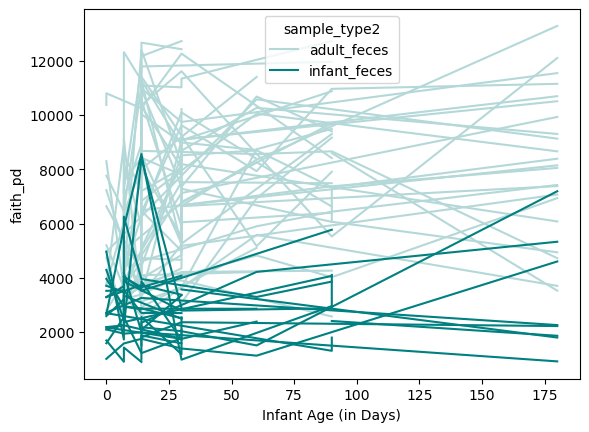

In [70]:
g = sns.lineplot(data=im_feces_faith, 
                 y='faith_pd', x='host_age_infant_cat', hue='sample_type2', 
                 units='host_subject_id', estimator=None,
                palette=['#B4D8D8','#008080'])
plt.rcParams['svg.fonttype'] = 'none'
plt.xlabel('Infant Age (in Days)')
#plt.savefig('../figures/both_feces_faith_unitlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

### Skin

In [71]:
i_skin_faith.host_subject_id.value_counts()

102681    7
120851    7
104281    7
108361    7
120381    7
115451    7
100771    7
106901    6
100581    6
111961    6
117051    6
104551    6
102511    6
117751    6
105211    6
111121    6
106811    6
103741    6
102911    6
110401    6
107341    6
114941    6
113391    6
113651    6
122811    5
114381    5
105711    5
123231    5
103951    5
114551    5
102541    5
122581    5
102281    5
114131    5
107271    5
119351    5
110901    5
119591    4
102861    4
115001    4
115471    4
121791    4
114341    4
101061    4
101371    4
101631    4
106841    4
104371    4
112151    4
123471    3
111991    3
103141    3
114591    2
104361    2
111871    2
Name: host_subject_id, dtype: int64

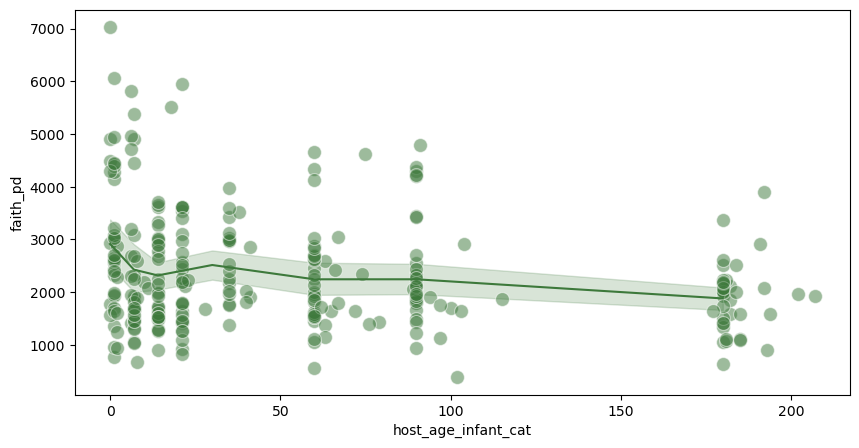

In [72]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=i_skin_faith, 
                 y='faith_pd', x='host_age_infant_cat', 
                color='#3D793B')
g = sns.scatterplot(data=i_skin_faith, 
                    y='faith_pd', x='host_age_infant', 
                color='#3D793B', alpha=0.5, s=100,)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_skin_faith_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [73]:
data = i_skin_faith.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1" )
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for faith alpha diversity for infant skin samples over time")
print(res.summary())

LME for faith alpha diversity for infant skin samples over time
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     faith_pd   
No. Observations:      279         Method:                 REML       
No. Groups:            55          Scale:                  934651.2859
Min. group size:       2           Log-Likelihood:         -2326.7392 
Max. group size:       7           Converged:              Yes        
Mean group size:       5.1                                            
----------------------------------------------------------------------
                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             2585.559  101.699 25.424 0.000 2386.232 2784.885
host_age_infant         -4.065    0.998 -4.074 0.000   -6.021   -2.109
host_subject_id Var 205091.907   85.001                               



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


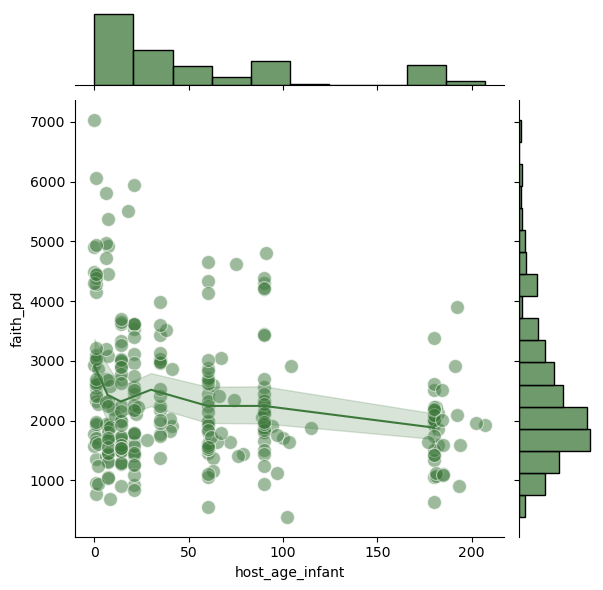

In [86]:
g = sns.jointplot(data=i_skin_faith, kind='scatter',
                  y='faith_pd', x='host_age_infant', color='#3D793B', s=100, alpha=0.5)

sns.lineplot(data=i_skin_faith,
             y='faith_pd', x='host_age_infant_cat',
             color='#3D793B',  
             ax=g.ax_joint) 

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_skin_faith_jointplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

30 days of age or less vs. older than 30 days: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.368e-01 U_stat=1.073e+04


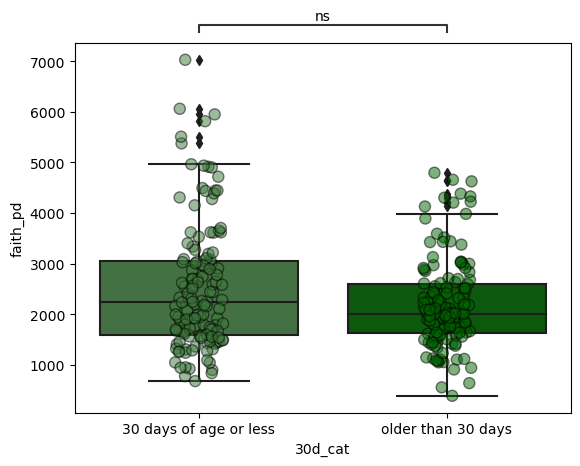

In [75]:
g = sns.boxplot(data=i_skin_faith, 
                 y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                palette=['#3D793B', 'darkgreen',])
g = sns.stripplot(data=i_skin_faith, 
                    y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                palette=['#3D793B', 'darkgreen',], s=8, linewidth=1, edgecolor='k', alpha=0.5)

pairs = [('older than 30 days', '30 days of age or less')]
annot = Annotator(g, pairs, data=i_skin_faith, 
                  x='30d_cat', y='faith_pd',
                 order=['30 days of age or less', 'older than 30 days'],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_skin_faith_boxswarmplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.797e-04 U_stat=1.116e+03


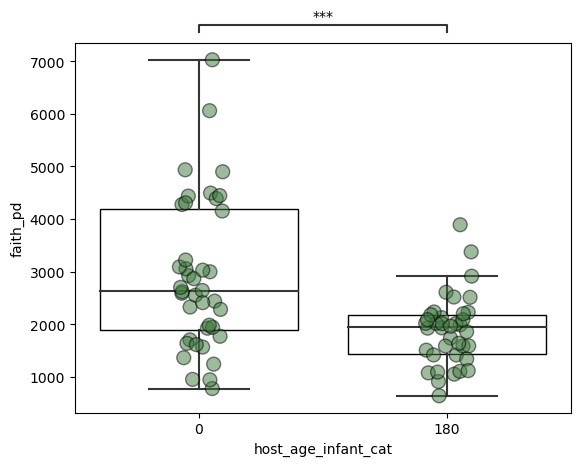

In [76]:
dfs = i_skin_faith[i_skin_faith['host_age_infant_cat'].isin([0,180])]
g = sns.boxplot(data=dfs, 
                 y='faith_pd', x='host_age_infant_cat', order=[0, 180],
                color='#3D793B',
               fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
g = sns.stripplot(data=dfs, 
                    y='faith_pd', x='host_age_infant_cat', order=[0, 180],
                color='#3D793B', s=10, linewidth=1, edgecolor='k', alpha=0.5)

pairs = [(0, 180)]
annot = Annotator(g, pairs, data=dfs, 
                  x='host_age_infant_cat', y='faith_pd',
                 order=[0, 180],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/infant_skin_faith_boxswarmplot_2tp.svg', dpi=150, bbox_inches='tight')
plt.show()

### Oral/Tongue

In [77]:
i_tongue_faith.host_subject_id.value_counts()

111961    7
108361    7
123231    7
106811    7
115471    7
121791    7
102911    7
114381    7
100771    7
102281    7
103951    7
115451    6
114591    6
111871    6
107271    6
104361    6
106901    6
120851    6
120381    6
110901    6
103741    6
122811    6
122581    6
117751    5
102681    5
111121    5
113651    5
117051    5
113391    5
119591    5
101631    5
115001    5
101061    5
123471    5
111991    5
114941    5
106841    5
104551    5
119351    5
105211    5
114131    5
105711    5
104281    5
107341    5
101371    5
104371    4
102541    4
110401    4
100581    4
102861    3
112151    3
114551    3
102511    2
114341    2
103141    1
Name: host_subject_id, dtype: int64

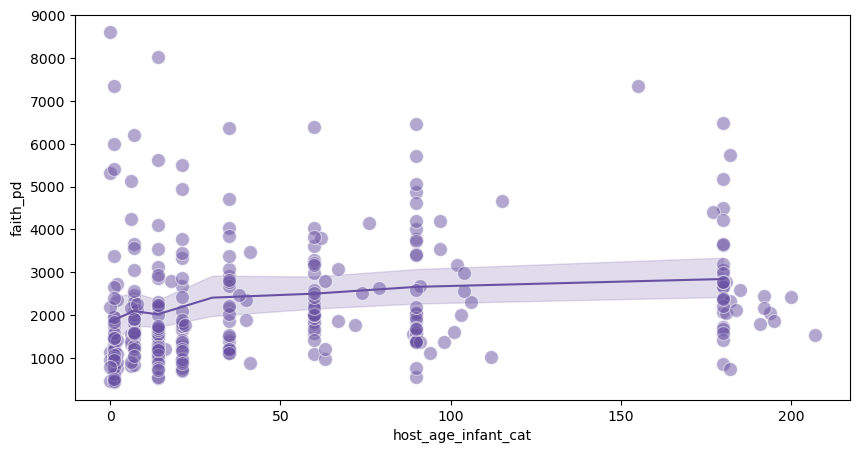

In [78]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=i_tongue_faith, 
                 y='faith_pd', x='host_age_infant_cat', 
                color='#6851A2')
g = sns.scatterplot(data=i_tongue_faith, 
                    y='faith_pd', x='host_age_infant', 
                color='#6851A2', alpha=0.5, s=100,)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/infant_oral_faith_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [79]:
data = i_tongue_faith.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1" )
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for faith alpha diversity for infant oral/tongue samples over time")
print(res.summary())

LME for faith alpha diversity for infant oral/tongue samples over time
                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    faith_pd    
No. Observations:      289        Method:                REML        
No. Groups:            55         Scale:                 1934014.9182
Min. group size:       1          Log-Likelihood:        -2498.8224  
Max. group size:       7          Converged:             Yes         
Mean group size:       5.3                                           
---------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            2031.881  116.697 17.412 0.000 1803.159 2260.603
host_age_infant         5.046    1.381  3.655 0.000    2.340    7.752
host_subject_id Var 69817.899   63.608                               



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


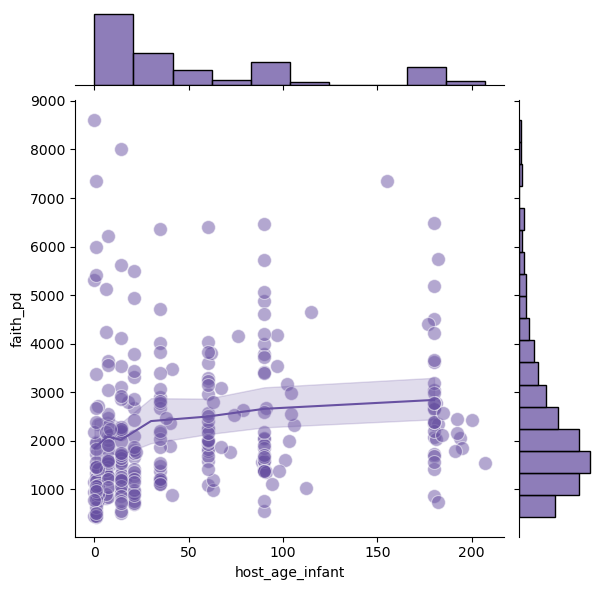

In [85]:
g = sns.jointplot(data=i_tongue_faith, kind='scatter',
                  y='faith_pd', x='host_age_infant', color='#6851A2', s=100, alpha=0.5)

sns.lineplot(data=i_tongue_faith,
             y='faith_pd', x='host_age_infant_cat',
             color='#6851A2',  
             ax=g.ax_joint) 

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_oral_faith_jointplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

30 days of age or less vs. older than 30 days: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.430e-08 U_stat=6.477e+03


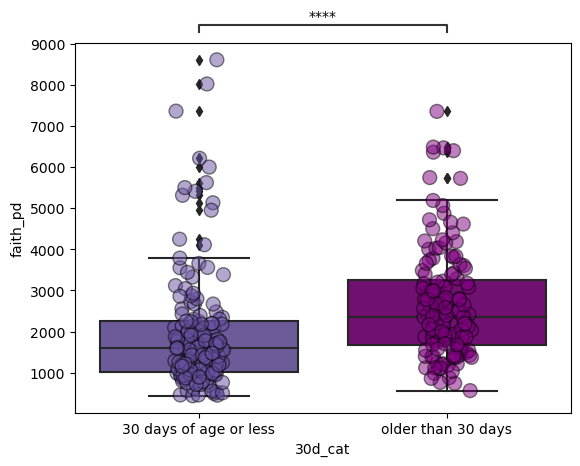

In [81]:
g = sns.boxplot(data=i_tongue_faith, 
                 y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                palette=['#6851A2', 'purple',])
g = sns.stripplot(data=i_tongue_faith, 
                    y='faith_pd', x='30d_cat', order=['30 days of age or less', 'older than 30 days'],
                palette=['#6851A2', 'purple',], s=10, linewidth=1, edgecolor='k', alpha=0.5)

pairs = [('older than 30 days', '30 days of age or less')]
annot = Annotator(g, pairs, data=i_tongue_faith, 
                  x='30d_cat', y='faith_pd',
                 order=['30 days of age or less', 'older than 30 days'],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_tongue_faith_boxswarmplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.976e-06 U_stat=3.930e+02


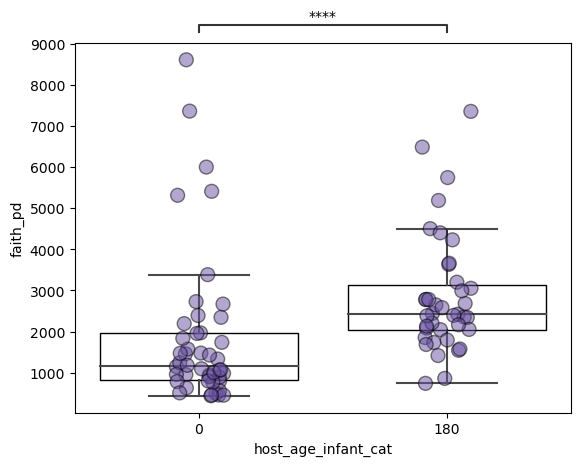

In [82]:
dft = i_tongue_faith[i_tongue_faith['host_age_infant_cat'].isin([0,180])]
g = sns.boxplot(data=dft, 
                 y='faith_pd', x='host_age_infant_cat', order=[0, 180],
                color='#6851A2',
               fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
g = sns.stripplot(data=dft, 
                    y='faith_pd', x='host_age_infant_cat', order=[0, 180],
                color='#6851A2', s=10, linewidth=1, edgecolor='k', alpha=0.5)

pairs = [(0, 180)]
annot = Annotator(g, pairs, data=dft, 
                  x='host_age_infant_cat', y='faith_pd',
                 order=[0, 180],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_tongue_faith_boxswarmplot_2tp.svg', dpi=150, bbox_inches='tight')
plt.show()

### Human Milk

In [83]:
m_milk_faith.host_subject_id.value_counts()

104370    2
120380    2
115450    2
100770    2
111960    2
114380    2
111870    2
104550    2
102680    2
111120    2
113390    2
122580    2
100580    2
123230    2
103950    2
102510    2
114590    2
119350    2
104360    2
113650    2
103740    2
105210    2
120850    2
115470    2
102280    2
119590    2
114130    2
114940    1
123470    1
122810    1
105710    1
106900    1
104280    1
117050    1
107270    1
103140    1
101630    1
106840    1
112150    1
101060    1
102540    1
111990    1
108360    1
102860    1
110900    1
115000    1
Name: host_subject_id, dtype: int64

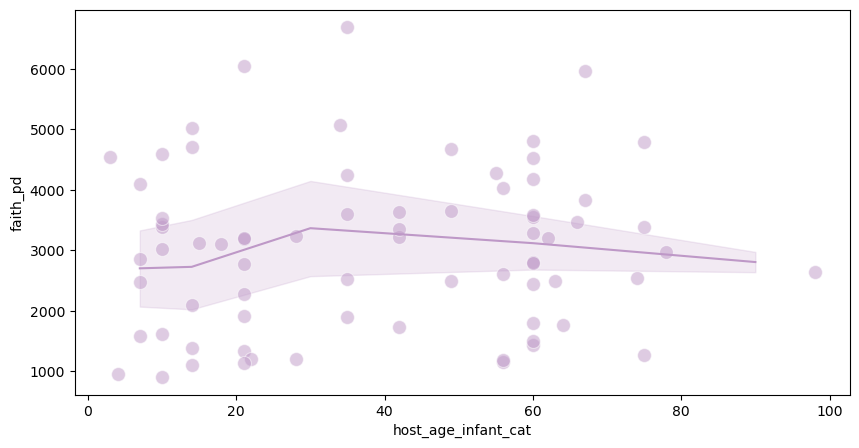

In [84]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=m_milk_faith[~(m_milk_faith['host_age_infant_cat']<7)], 
                 y='faith_pd', x='host_age_infant_cat',
                color='#BE98C7')
g = sns.scatterplot(data=m_milk_faith, 
                    y='faith_pd', x='host_age_infant',
                color='#BE98C7', alpha=0.5, s=100)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/adult_milk_faith_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [87]:
data = m_milk_faith.copy()
data.dropna(subset=['faith_pd'], inplace=True) #need to drop nans
model = smf.mixedlm("faith_pd~host_age_infant", data, 
                        groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
print("LME for faith alpha diversity for maternal milk samples over time")
print(res.summary())

LME for faith alpha diversity for maternal milk samples over time
                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    faith_pd    
No. Observations:      73         Method:                REML        
No. Groups:            46         Scale:                 1570770.0858
Min. group size:       1          Log-Likelihood:        -618.7780   
Max. group size:       2          Converged:             Yes         
Mean group size:       1.6                                           
---------------------------------------------------------------------
                      Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept             2796.662  307.702 9.089 0.000 2193.577 3399.747
host_age_infant          5.291    6.557 0.807 0.420   -7.561   18.143
host_subject_id Var 201883.066  371.355                              



/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


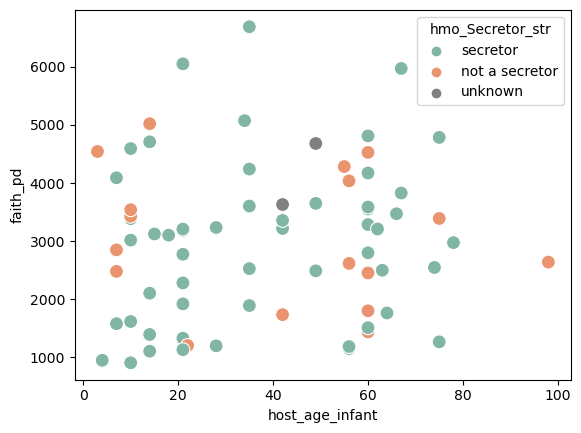

In [88]:
g = sns.scatterplot(data=m_milk_faith, 
                    y='faith_pd', x='host_age_infant', hue='hmo_Secretor_str',
                palette=['#80B6A3', '#E9946E', 'grey'], s=100)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/human_milk_faith_secretor_scatterlineplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [89]:
g = sns.jointplot(data=m_milk_faith, kind='scatter',
                  y='faith_pd', x='host_age_infant', color='#BE98C7', s=100, alpha=0.5)

sns.lineplot(data=m_milk_faith[~(m_milk_faith['host_age_infant_cat'] < 7)],
             y='faith_pd', x='host_age_infant_cat',
             color='#BE98C7',  
             ax=g.ax_joint) 

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/human_milk_faith_jointplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [90]:
g = sns.boxplot(data=m_milk_faith[m_milk_faith['hmo_Secretor_str']!='unknown'], 
                 y='faith_pd', x='hmo_Secretor_str', 
                palette=['#80B6A3', '#E9946E',])
g = sns.swarmplot(data=m_milk_faith[m_milk_faith['hmo_Secretor_str']!='unknown'], 
                    y='faith_pd', x='hmo_Secretor_str',
                palette=['#80B6A3', '#E9946E',], s=10, linewidth=1, edgecolor='grey')

pairs = [('secretor', 'not a secretor')]
annot = Annotator(g, pairs, data=m_milk_faith[m_milk_faith['hmo_Secretor_str']!='unknown'], 
                  x='hmo_Secretor_str', y='faith_pd',)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_milk_faith_secretor_boxswarmplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

secretor vs. not a secretor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.966e-01 U_stat=4.470e+02


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

30 days of age or less vs. older than 30 days: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.304e-02 U_stat=5.000e+02


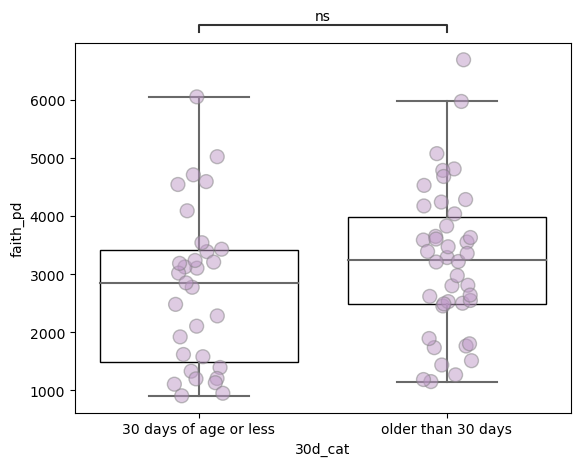

In [91]:
g = sns.boxplot(data=m_milk_faith, 
                 y='faith_pd', x='30d_cat', 
                color='#BE98C7',
               fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
g = sns.stripplot(data=m_milk_faith, 
                    y='faith_pd', x='30d_cat', alpha=0.5,
                color='#BE98C7', s=10, linewidth=1, edgecolor='grey')

pairs = [('older than 30 days', '30 days of age or less')]
annot = Annotator(g, pairs, data=m_milk_faith, x='30d_cat', y='faith_pd',)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_milk_faith_3d_boxswarmplot.svg', dpi=150, bbox_inches='tight')
plt.show()

### Vaginal - Day0/Birth

In [92]:
m_vaginal_faith.host_subject_id.value_counts()

105210    1
115450    1
121790    1
110900    1
114590    1
102510    1
119590    1
102540    1
102860    1
108360    1
105710    1
104550    1
104370    1
100770    1
122580    1
111960    1
120380    1
111120    1
120850    1
114130    1
106810    1
122810    1
115000    1
115470    1
104360    1
102280    1
123470    1
110400    1
102910    1
107270    1
106900    1
107340    1
100580    1
101370    1
112150    1
106840    1
114940    1
102680    1
Name: host_subject_id, dtype: int64

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Vaginal vs. C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.403e-01 U_stat=2.190e+02


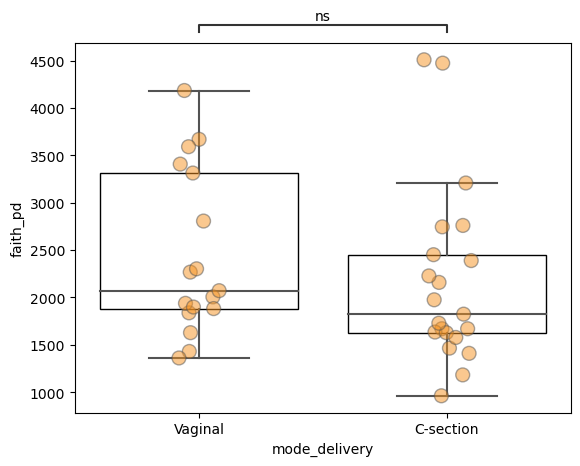

In [93]:
g = sns.boxplot(data=m_vaginal_faith, 
                 y='faith_pd', x='mode_delivery', 
                color='#F69320',
               fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
g = sns.stripplot(data=m_vaginal_faith, alpha=0.5,
                    y='faith_pd', x='mode_delivery',
                color='#F69320', s=10, linewidth=1)

pairs = [('Vaginal', 'C-section')]
annot = Annotator(g, pairs, data=m_vaginal_faith, x='mode_delivery', y='faith_pd',)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside',
                        correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/adult_vaginal_faith_boxswarmplot.svg', dpi=150, bbox_inches='tight')
plt.show()

# ANCOM-BC2

### fecal

In [96]:
qval = pd.read_csv('../../data/Microbiome/ancombc2/infant_fecal_ancombc2_genus-diff_early-late/q.csv')
qval.drop(qval.index[0], inplace=True)
qval.rename(columns={'30d_cat::older than 30 days':'q-value'}, inplace=True)
qval.head()

(Intercept)       q-value  description direction doctype extra fields  \
1     0.019693  1.698673e-04          NaN       NaN     NaN   NaN    NaN   
2     1.000000  1.000000e+00          NaN       NaN     NaN   NaN    NaN   
3     0.006541  1.000000e+00          NaN       NaN     NaN   NaN    NaN   
4     1.000000  6.590000e-08          NaN       NaN     NaN   NaN    NaN   
5     1.000000  0.000000e+00          NaN       NaN     NaN   NaN    NaN   

  index style                                              taxon  title  
1   NaN   NaN  d__Bacteria;p__Actinomycetota;c__Actinomycetes...    NaN  
2   NaN   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN  
3   NaN   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN  
4   NaN   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Sta...    NaN  
5   NaN   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN

In [98]:
lfc = pd.read_csv('../../data/Microbiome/ancombc2/infant_fecal_ancombc2_genus-diff_early-late/lfc.csv')
lfc.drop(lfc.index[0], inplace=True)
lfc.rename(columns={'30d_cat::older than 30 days':'lfc'}, inplace=True)
lfc.head()

(Intercept)       lfc  description direction doctype extra fields index  \
1    -0.587176  1.528803          NaN       NaN     NaN   NaN    NaN   NaN   
2    -0.112382  0.691027          NaN       NaN     NaN   NaN    NaN   NaN   
3     0.483849 -0.332102          NaN       NaN     NaN   NaN    NaN   NaN   
4     0.095579 -1.943410          NaN       NaN     NaN   NaN    NaN   NaN   
5    -0.229963 -2.941663          NaN       NaN     NaN   NaN    NaN   NaN   

  style                                              taxon  title  
1   NaN  d__Bacteria;p__Actinomycetota;c__Actinomycetes...    NaN  
2   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN  
3   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN  
4   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Sta...    NaN  
5   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN

In [100]:
se = pd.read_csv('../../data/Microbiome/ancombc2/infant_fecal_ancombc2_genus-diff_early-late/se.csv')
se.drop(se.index[0], inplace=True)
se.rename(columns={'30d_cat::older than 30 days':'se'}, inplace=True)
se.head()

(Intercept)        se  description direction doctype extra fields index  \
1     0.154012  0.306066          NaN       NaN     NaN   NaN    NaN   NaN   
2     0.220323  0.390168          NaN       NaN     NaN   NaN    NaN   NaN   
3     0.111743  0.207590          NaN       NaN     NaN   NaN    NaN   NaN   
4     0.199929  0.279597          NaN       NaN     NaN   NaN    NaN   NaN   
5     0.144998  0.213804          NaN       NaN     NaN   NaN    NaN   NaN   

  style                                              taxon  title  
1   NaN  d__Bacteria;p__Actinomycetota;c__Actinomycetes...    NaN  
2   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN  
3   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN  
4   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Sta...    NaN  
5   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN

In [101]:
ifecal = pd.merge(qval[['taxon', 'q-value']],
               lfc[['taxon', 'lfc']],
               left_on='taxon', right_on='taxon')
ifecal2 = pd.merge(ifecal, se[['taxon', 'se']],
                  left_on='taxon', right_on='taxon')
ifecal2.head()

taxon       q-value       lfc  \
0  d__Bacteria;p__Actinomycetota;c__Actinomycetes...  1.698673e-04  1.528803   
1  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...  1.000000e+00  0.691027   
2  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...  1.000000e+00 -0.332102   
3  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Sta...  6.590000e-08 -1.943410   
4  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...  0.000000e+00 -2.941663   

         se  
0  0.306066  
1  0.390168  
2  0.207590  
3  0.279597  
4  0.213804

In [102]:
ifecal2['genus'] = ifecal2['taxon'].str.split(";").str[-1]

In [103]:
sig_ifecal = ifecal2[(ifecal2['q-value']<0.05)&(abs(ifecal2['lfc'])>0.5)].copy()
sig_ifecal.sort_values(by='lfc')
sig_ifecal.shape

(55, 5)

In [104]:
sig_ifecal.taxon.values

array(['d__Bacteria;p__Actinomycetota;c__Actinomycetes;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium',
       'd__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus',
       'd__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus_H_360604',
       'd__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lactobacillales;f__Lactobacillaceae;g__Ligilactobacillus',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Peptostreptococcales;f__Peptostreptococcaceae_256921;g__Clostridioides_A',
       'd__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lactobacillales;f__Lactobacillaceae;g__Limosilactobacillus',
       'd__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
       'd__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lactobacillales;f__Lactobacillaceae;g__Lacticaseibacillus',
       'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales_73

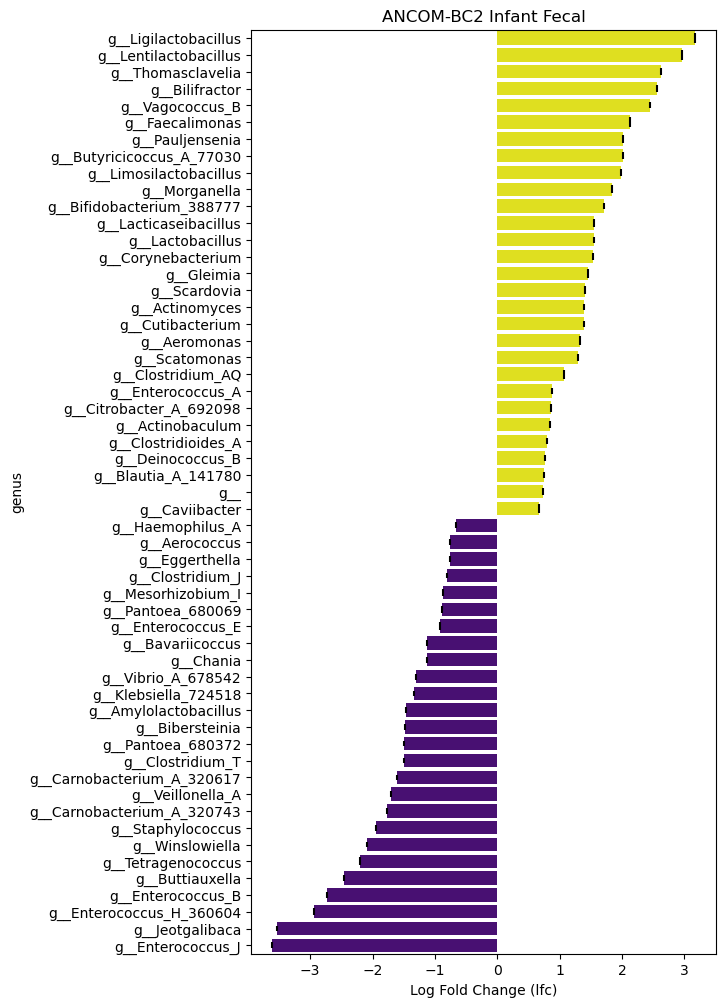

In [105]:
plt.figure(figsize=(6, 12))
sort_sig_ifecal = sig_ifecal.sort_values(by='lfc', ascending=False)
#colors = ['darkred' if lfc > 0 else 'tomato' for lfc in sort_sig_ifecal['lfc']]
colors = ['yellow' if lfc > 0 else 'indigo' for lfc in sort_sig_ifecal['lfc']]

sns.barplot(data=sort_sig_ifecal, 
            x='lfc', y='genus', yerr=sig_ifecal['se'], 
            capsize=0.2, palette=colors)

plt.title('ANCOM-BC2 Infant Fecal')
plt.xlabel('Log Fold Change (lfc)')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/ancombc2_ifeces_barplot.svg', dpi=150, bbox_inches='tight')
plt.show()

In [106]:
top_12 = sort_sig_ifecal.head(12)
bottom_12 = sort_sig_ifecal.tail(12)

sort_sig_ifecal_12 = pd.concat([top_12, bottom_12])
sort_sig_ifecal_12.shape

(24, 5)

In [107]:
sort_sig_ifecal_12.head()

taxon       q-value  \
5    d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...  7.645887e-17   
36   d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...  2.000000e-10   
28   d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Ery...  1.860000e-08   
109  d__Bacteria;p__Bacillota_A_368345;c__Clostridi...  1.000000e-10   
97   d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...  0.000000e+00   

          lfc        se                  genus  
5    3.166682  0.226658   g__Ligilactobacillus  
36   2.953018  0.194510  g__Lentilactobacillus  
28   2.619350  0.243243      g__Thomasclavelia  
109  2.559783  0.178490         g__Bilifractor  
97   2.453762  0.244392        g__Vagococcus_B

In [108]:
plt.figure(figsize=(6, 12))
colors = ['yellow' if lfc > 0 else 'indigo' for lfc in sort_sig_ifecal_12['lfc']]

sns.barplot(data=sort_sig_ifecal_12, 
            x='lfc', y='genus', yerr=sort_sig_ifecal_12['se'], 
            capsize=0.2, palette=colors)

plt.title('ANCOM-BC2 Infant Fecal')
plt.xlabel('Log Fold Change (LFC)')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/ancombc2_ifeces_barplot_12_viridis.svg', dpi=150, bbox_inches='tight')
plt.show()

#### log ratios

In [109]:
gftable = pd.read_csv('../../data/Microbiome/ftable_infant_feces_min10-5_genus/feature-table.tsv',
                     sep='\t', skiprows=1, index_col=0)
gftable.head()

14834.93126  14834.43909  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0       5968.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.23869  14834.22843  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...       2146.0        923.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          6.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.99362  14834.49809  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...        123.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          2.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.31950  14834.23900  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        185.0      40744.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...   11446802.0     611016.0   

                                                    14834.41696  14834.42788  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          2.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...      20878.0      30998.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0     297481.0   

                                                    ...  14834.38785  \
#OTU ID                                             ...                
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...  ...         17.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...  ...          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...  ...          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...          0.0   

                                                    14834.49564  14834.52820  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0          3.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        910.0      10100.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.93742  14834.40412  \
#OTU ID                                                                        
d__Bacteria;p__Actino

In [110]:
Numerator = sort_sig_ifecal[sort_sig_ifecal.lfc>0].taxon.values
Denominator = sort_sig_ifecal[sort_sig_ifecal.lfc<0].taxon.values

In [111]:
gftable2 = gftable.T.copy()
gftable2['log-ratio'] = np.log(gftable2[Numerator].sum(axis=1)) - np.log(gftable2[Denominator].sum(axis=1))
gftable2.shape

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(219, 682)

In [112]:
gftable3 = gftable2[['log-ratio']].copy()
gftable3['log-ratio'] = gftable3['log-ratio'].replace([np.inf, -np.inf], np.nan)
gftable3.shape

(219, 1)

In [113]:
gftable3['log-ratio'].isnull().sum()

42

In [114]:
gft_md = pd.merge(gftable3, metadata, left_index=True, right_index=True)
gft_md.shape

(219, 77)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 0: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.000e+00 U_stat=5.445e+02
0 vs. 7: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.467e-02 U_stat=9.470e+02
0 vs. 14: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.653e-01 U_stat=4.780e+02
0 vs. 30: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.518e-01 U_stat=2.640e+02
0 vs. 60: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.014e-02 (ns) U_stat=1.010e+02
0 vs. 90: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.384e-04 U_stat=1.050e+02
0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.728e-03 U_stat=1.140e+02


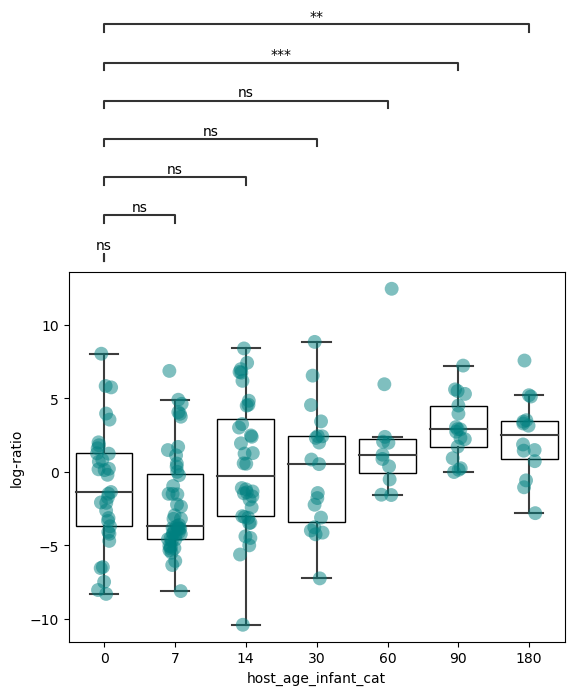

In [116]:
ax = sns.boxplot(data=gft_md, y='log-ratio', x='host_age_infant_cat', 
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=gft_md, y='log-ratio', x='host_age_infant_cat',
                  size=10, alpha=0.5, color='#008080')

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [(0, tp) for tp in gft_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=gft_md, y='log-ratio', x='host_age_infant_cat')
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

In [117]:
g = sns.regplot(data=gft_md, y='log-ratio', x='host_age_infant', 
                color='#008080', lowess=True, line_kws=dict(color="k"))

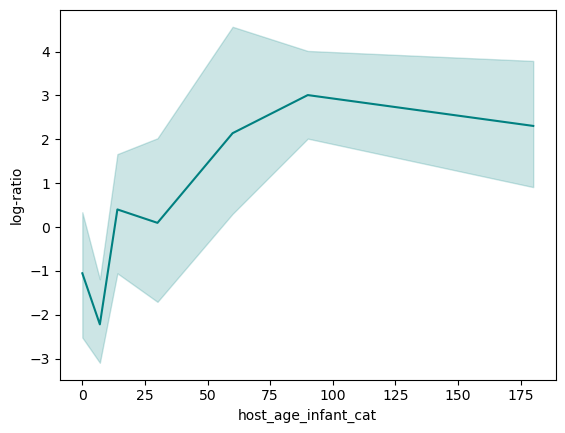

In [118]:
g = sns.lineplot(data=gft_md, y='log-ratio', x='host_age_infant_cat', 
                color='#008080')

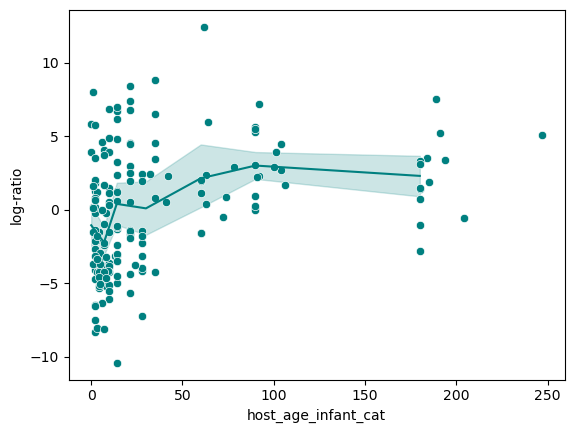

In [119]:
g = sns.lineplot(data=gft_md, y='log-ratio', x='host_age_infant_cat', 
                color='#008080')
g = sns.scatterplot(data=gft_md, y='log-ratio', x='host_age_infant', 
                color='#008080')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/infant_feces_lr_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

In [120]:
gft_md.head()

log-ratio age_enrollment_study  collection_date  \
14834.93126        NaN                    1             2021   
14834.43909        NaN                    1             2021   
14834.23869  -3.198902                    1             2021   
14834.22843   3.963060                    0             2021   
14834.99362   1.437127                    1             2021   

             collection_timestamp     country   description  dna_extracted  \
14834.93126                  2021  Bangladesh  infant stool           True   
14834.43909                  2021  Bangladesh  infant stool           True   
14834.23869                  2021  Bangladesh  infant stool           True   
14834.22843                  2021  Bangladesh  infant stool           True   
14834.99362                  2021  Bangladesh  infant stool           True   

             elevation           empo_1                        empo_2  ...  \
14834.93126         32  Host-associated  Host-associated (non-saline)  ...   
14834.43909         32  Host-associated  Host-associated (non-saline)  ...   
14834.23869         32  Host-associated  Host-associated (non-saline)  ...   
14834.22843         32  Host-associated  Host-associated (non-saline)  ...   
14834.99362         32  Host-associated  Host-associated (non-saline)  ...   

            hmo_Secretor    drink_water_safe drink_water_safe_simplified  \
14834.93126            1  boil_filter_strain                     Treated   
14834.43909            1             nothing                   Untreated   
14834.23869            0                boil                     Treated   
14834.22843            0             nothing                   Untreated   
14834.99362            0                boil                     Treated   

            sample_type_binary host_age_infant_cat hmo_Secretor_str  \
14834.93126             sample                  90         secretor   
14834.43909             sample                  14         secretor   
14834.23869             sample                   7   not a secretor   
14834.22843             sample                   0   not a secretor   
14834.99362             sample                 180   not a secretor   

             sample_type2         delivery_bf-cat SourceSink  \
14834.93126  infant_feces           C-section_EBF       Sink   
14834.43909  infant_feces             Vaginal_EBF       Sink   
14834.23869  infant_feces  Vaginal_Predominant BF       Sink   
14834.22843  infant_feces             Vaginal_EBF       Sink   
14834.99362  infant_feces    C-section_Partial BF       Sink   

                            30d_cat  
14834.93126      older than 30 days  
14834.43909  30 days of age or less  
14834.23869  30 days of age or less  
14834.22843  30 days of age or less  
14834.99362      older than 30 days  

[5 rows x 77 columns]

In [121]:
data = gft_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant", data, 
                    groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM   Dependent Variable:   log_ratio
No. Observations:    177       Method:               REML     
No. Groups:          53        Scale:                11.5568  
Min. group size:     1         Log-Likelihood:       -487.7834
Max. group size:     7         Converged:            Yes      
Mean group size:     3.3                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.953    0.415 -2.294 0.022 -1.767 -0.139
host_age_infant      0.026    0.005  5.139 0.000  0.016  0.036
host_subject_id Var  3.196    0.432                           
==============================================================

"""

In [126]:
gftx = gft_md[gft_md['host_age_infant_cat']==0].copy()
gftx['log-ratio'].mean()

-1.0525553736081432

In [128]:
gftx = gft_md[gft_md['host_age_infant_cat']==60].copy()
gftx['log-ratio'].mean()

2.14107303456872

In [129]:
g = sns.lineplot(data=gft_md, y='log-ratio', x='host_age_infant_cat', 
                hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'])
g = sns.scatterplot(data=gft_md, y='log-ratio', x='host_age_infant', 
                hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'])
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_boxplot_long_delmode.svg', dpi=150, bbox_inches='tight')
plt.show()

In [130]:
data = gft_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant*mode_delivery", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                      MixedLM          Dependent Variable:          log_ratio
No. Observations:           177              Method:                      REML     
No. Groups:                 53               Scale:                       11.4762  
Min. group size:            1                Log-Likelihood:              -487.2915
Max. group size:            7                Converged:                   Yes      
Mean group size:            3.3                                                    
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                -2.165    0.600 -3.607 0.000 -3.341 -0.988
mode_delivery[T.Vaginal]                  2.165    0.805  2.688 0.007  0.586  3.744
host_age_infant                           0.036    0.008  4.300 0.000  0.020  0.053
host_age_infant:mode_delivery[T.Vaginal] -0.017    0.011 -1.564 0.118 -0.037  0.004
host_subject_id Var                       2.666    0.409                           
===================================================================================

"""

In [132]:
ax = sns.boxplot(data=gft_md, y='log-ratio', x='host_age_infant_cat', 
                 hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'],
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=gft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'],
                  size=10, alpha=0.5, dodge=True)

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [((tp,'Vaginal'), (tp, 'C-section')) for tp in gft_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=gft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='mode_delivery', hue_order=['Vaginal', 'C-section'],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_delmode_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

7_Vaginal vs. 7_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.151e-03 U_stat=4.040e+02
0_Vaginal vs. 0_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.028e-01 U_stat=1.640e+02
14_Vaginal vs. 14_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.613e-01 U_stat=1.680e+02
90_Vaginal vs. 90_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.884e-01 U_stat=3.800e+01
180_Vaginal vs. 180_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.064e-01 U_stat=2.700e+01
30_Vaginal vs. 30_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.522e-01 U_stat=4.500e+01
60_Vaginal vs. 60_

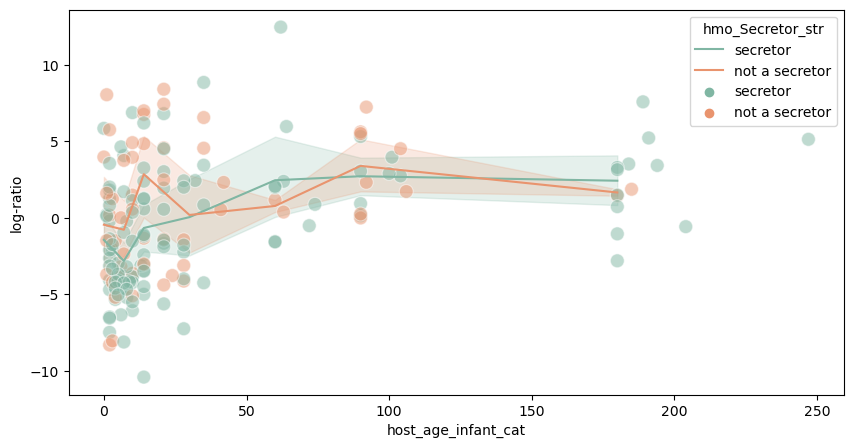

In [133]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=gft_md[gft_md['hmo_Secretor_str']!='unknown'], 
                 y='log-ratio', x='host_age_infant_cat', 
                hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'], palette=['#80B6A3', '#E9946E'])
g = sns.scatterplot(data=gft_md[gft_md['hmo_Secretor_str']!='unknown'], 
                    y='log-ratio', x='host_age_infant', 
                hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'], palette=['#80B6A3', '#E9946E'],
                   alpha=0.5, s=100)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_boxplot_long_secretor.svg', dpi=150, bbox_inches='tight')
plt.show()

In [134]:
data = gft_md[gft_md['hmo_Secretor_str']!='unknown'].copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant*hmo_Secretor_str", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                        MixedLM           Dependent Variable:           log_ratio
No. Observations:             172               Method:                       REML     
No. Groups:                   52                Scale:                        11.9319  
Min. group size:              1                 Log-Likelihood:               -477.0272
Max. group size:              7                 Converged:                    Yes      
Mean group size:              3.3                                                      
---------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                     0.093    0.749  0.124 0.902 -1.376  1.561
hmo_Secretor_str[T.secretor]                 -1.581    0.904 -1.749 0.080 -3.352  0.191
host_age_infant                               0.026    0.012  2.188 0.029  0.003  0.049
host_age_infant:hmo_Secretor_str[T.secretor]  0.001    0.013  0.073 0.941 -0.025  0.027
host_subject_id Var                           2.863    0.422                           
=======================================================================================

"""

In [135]:
data = gft_md[gft_md['hmo_Secretor_str']!='unknown'].copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant*hmo_Secretor_str*fp_crosssec_3cat", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Mixed Linear Model Regression Results
===============================================================================================================
Model:                                MixedLM                   Dependent Variable:                   log_ratio
No. Observations:                     172                       Method:                               REML     
No. Groups:                           52                        Scale:                                11.5672  
Min. group size:                      1                         Log-Likelihood:                       -477.5575
Max. group size:                      7                         Converged:                            Yes      
Mean group size:                      3.3                                                                      
---------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                                             0.462    2.385  0.194 0.846 -4.213  5.137
hmo_Secretor_str[T.secretor]                                         -0.185    2.690 -0.069 0.945 -5.457  5.087
fp_crosssec_3cat[T.EBF]                                              -0.196    2.409 -0.081 0.935 -4.918  4.526
hmo_Secretor_str[T.secretor]:fp_crosssec_3cat[T.EBF]                 -1.974    2.742 -0.720 0.472 -7.347  3.400
host_age_infant                                                       0.025    0.023  1.089 0.276 -0.020  0.069
host_age_infant:hmo_Secretor_str[T.secretor]                         -0.014    0.025 -0.558 0.577 -0.062  0.034
host_age_infant:fp_crosssec_3cat[T.EBF]                              -0.015    0.044 -0.348 0.728 -0.102  0.071
host_age_infant:hmo_Secretor_str[T.secretor]:fp_crosssec_3cat[T.EBF]  0.047    0.047  0.998 0.318 -0.045  0.138
host_subject_id Var                                                   3.366    0.495                           
===============================================================================================================

"""

In [136]:
conditions = [
    gft_md['host_age_infant'] <= 5,
    (gft_md['host_age_infant'] >= 6) & (gft_md['host_age_infant'] <= 14),
    gft_md['host_age_infant'] > 14
]

choices = ['colostrum', 'transitional', 'mature']

gft_md['hmo_time_group'] = np.select(conditions, choices, default='Unknown') 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

transitional_secretor vs. transitional_not a secretor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.945e-02 (ns) U_stat=1.940e+02
colostrum_secretor vs. colostrum_not a secretor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.199e-01 U_stat=1.640e+02
mature_secretor vs. mature_not a secretor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.469e-01 U_stat=5.950e+02


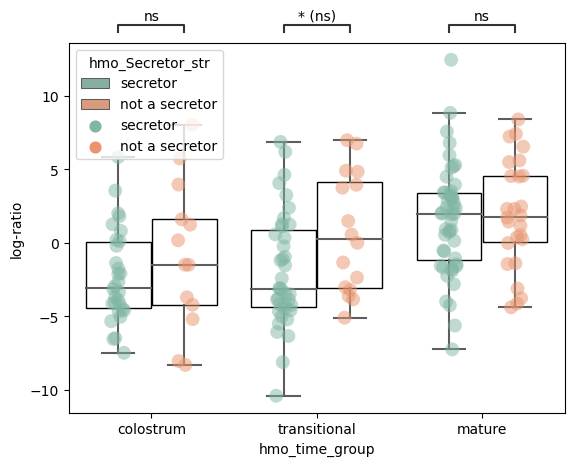

In [137]:
ax = sns.boxplot(data=gft_md, y='log-ratio', x='hmo_time_group', order=['colostrum', 'transitional', 'mature'],
                 hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'], palette=['#80B6A3', '#E9946E'],
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=gft_md, y='log-ratio', x='hmo_time_group',order=['colostrum', 'transitional', 'mature'],
                   hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'], palette=['#80B6A3', '#E9946E'],
                  size=10, alpha=0.5, dodge=True)

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [((tp,'secretor'), (tp, 'not a secretor')) for tp in gft_md['hmo_time_group'].unique()]
annot = Annotator(ax, pairs, data=gft_md, y='log-ratio', x='hmo_time_group', order=['colostrum', 'transitional', 'mature'],
                 hue='hmo_Secretor_str', hue_order=['secretor', 'not a secretor'],)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                     verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_secretor_hmo-tp_boxplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

7_Untreated vs. 7_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.007e-01 U_stat=2.540e+02
0_Untreated vs. 0_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.385e-01 U_stat=9.400e+01
14_Untreated vs. 14_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.050e-02 (ns) U_stat=7.400e+01
90_Untreated vs. 90_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.593e-01 U_stat=3.100e+01
180_Untreated vs. 180_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.728e-01 U_stat=2.900e+01
30_Untreated vs. 30_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.000e+00 U_stat=3.900e+01
60_Untreated 

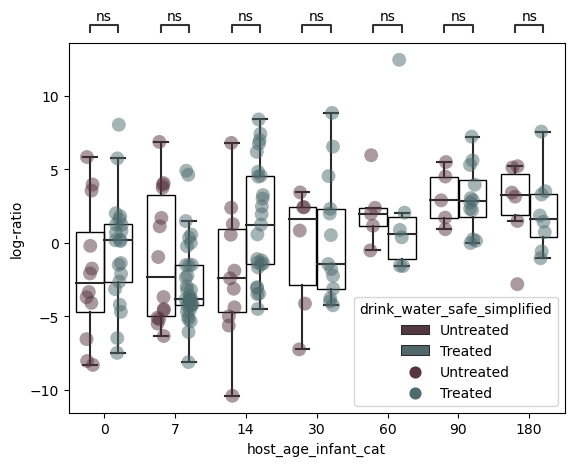

In [138]:
ax = sns.boxplot(data=gft_md, y='log-ratio', x='host_age_infant_cat', 
                 hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'], 
                 palette=['#563440', '#4D6A6D'],
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=gft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'], 
                 palette=['#563440', '#4D6A6D'],
                  size=10, alpha=0.5, dodge=True)

pairs = [((tp,'Untreated'), (tp, 'Treated')) for tp in gft_md['host_age_infant_cat'].unique()]
#pairs = [((14,'no water treatment'), (14, 'filtered'))]
annot = Annotator(ax, pairs, data=gft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'], )
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_watertx_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

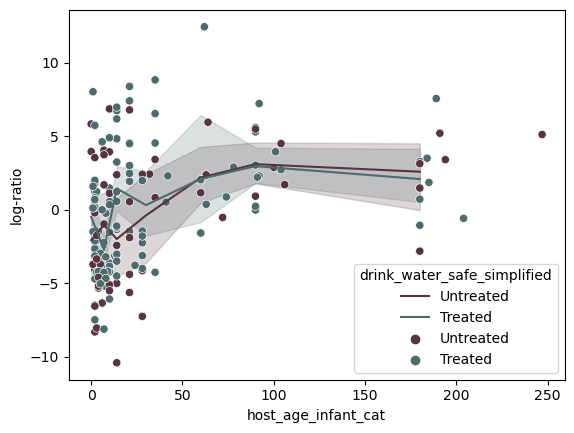

In [139]:
g = sns.lineplot(data=gft_md, y='log-ratio', x='host_age_infant_cat', 
                hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'],
                palette=['#563440', '#4D6A6D'])
g = sns.scatterplot(data=gft_md, y='log-ratio', x='host_age_infant', 
                hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'],
                   palette=['#563440', '#4D6A6D'])
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_boxplot_long_water.svg', dpi=150, bbox_inches='tight')
plt.show()

#### apply to adult samples

In [141]:
agftable = pd.read_csv('../../data/Microbiome/ftable_adult_feces_min10-5_genus/feature-table.tsv',
                     sep='\t', skiprows=1, index_col=0)
agftable.head()

14834.50560  14834.71261  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        127.0     172177.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...    1527463.0          0.0   

                                                    14834.39321  14834.39524  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...        564.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...      22423.0         35.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.52169  14834.32751  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...       4181.0        114.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          8.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     656063.0    1056442.0   

                                                    14834.71970  14834.50384  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...         19.0       1120.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...     134062.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.33393  14834.49749  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0       1260.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        861.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     902950.0          0.0   

                                                    ...  14834.72944  \
#OTU ID                                             ...                
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...  ...          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...  ...          3.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...  ...          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...      61551.0   

                                                    14834.97936  14834.44586  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0         77.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          4.0         74.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0         19.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.23734  14834.39826  \
#OTU ID                                                                        
d__Bacteria;p__Actino

In [144]:
Numerator = sort_sig_ifecal[sort_sig_ifecal.lfc>0].taxon.values
Denominator = sort_sig_ifecal[sort_sig_ifecal.lfc<0].taxon.values

In [149]:
Num = agftable2.columns[agftable2.columns.isin(Numerator)]
Denom = agftable2.columns[agftable2.columns.isin(Denominator)]

In [150]:
agftable2 = agftable.T.copy()
agftable2['log-ratio'] = np.log(agftable2[Num].sum(axis=1)) - np.log(agftable2[Denom].sum(axis=1))
agftable2.shape

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(354, 715)

In [151]:
agftable3 = agftable2[['log-ratio']].copy()
agftable3['log-ratio'] = agftable3['log-ratio'].replace([np.inf, -np.inf], np.nan)
agftable3.shape

(354, 1)

In [152]:
agftable3['log-ratio'].isnull().sum()

15

In [153]:
agft_md = pd.merge(agftable3, metadata, left_index=True, right_index=True)
agft_md.shape

(354, 77)

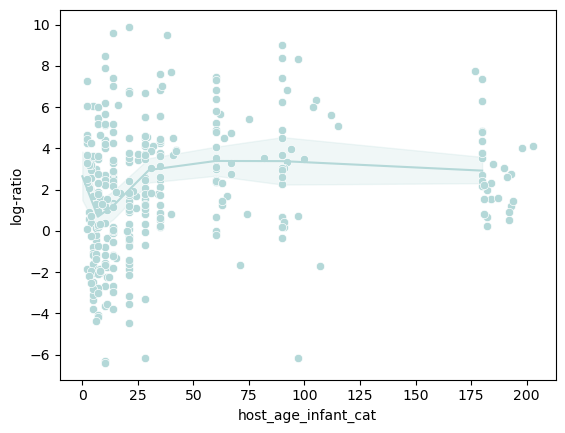

In [154]:
g = sns.lineplot(data=agft_md, y='log-ratio', x='host_age_infant_cat', 
                color='#B4D8D8')
g = sns.scatterplot(data=agft_md, y='log-ratio', x='host_age_infant', 
                color='#B4D8D8')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_feces_lr_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

In [155]:
data = agft_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant_cat", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  log_ratio
No. Observations:    339      Method:              REML     
No. Groups:          55       Scale:               7.8246   
Min. group size:     4        Log-Likelihood:      -849.2494
Max. group size:     7        Converged:           Yes      
Mean group size:     6.2                                    
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           1.561    0.238 6.561 0.000  1.095  2.027
host_age_infant_cat 0.013    0.003 4.167 0.000  0.007  0.019
host_subject_id Var 0.922    0.165                          
============================================================

"""

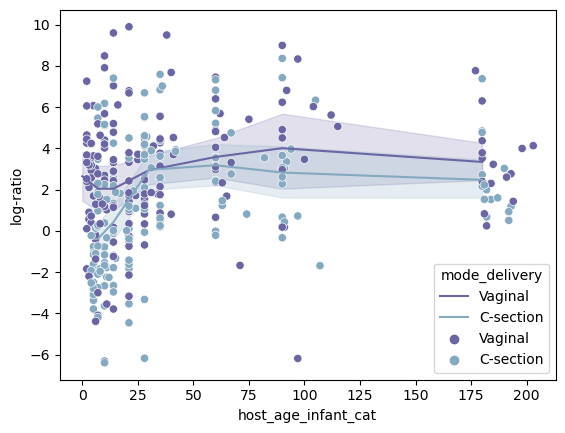

In [156]:
g = sns.lineplot(data=agft_md, y='log-ratio', x='host_age_infant_cat', 
                hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'])
g = sns.scatterplot(data=agft_md, y='log-ratio', x='host_age_infant', 
                hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'])
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_feces_lr_boxplot_long_delmode.svg', dpi=150, bbox_inches='tight')
plt.show()

In [157]:
data = agft_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant_cat*mode_delivery", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with powell
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                        MixedLM           Dependent Variable:           log_ratio
No. Observations:             339               Method:                       REML     
No. Groups:                   55                Scale:                        7.7630   
Min. group size:              4                 Log-Likelihood:               -846.1435
Max. group size:              7                 Converged:                    Yes      
Mean group size:              6.2                                                      
---------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                     0.666    0.320  2.083 0.037  0.039  1.292
mode_delivery[T.Vaginal]                      1.719    0.444  3.876 0.000  0.850  2.589
host_age_infant_cat                           0.018    0.004  4.021 0.000  0.009  0.026
host_age_infant_cat:mode_delivery[T.Vaginal] -0.009    0.006 -1.474 0.141 -0.021  0.003
host_subject_id Var                           0.541    0.137                           
=======================================================================================

"""

In [158]:
ax = sns.boxplot(data=agft_md, y='log-ratio', x='host_age_infant_cat', 
                 hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'],
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=agft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='mode_delivery', hue_order=['Vaginal', 'C-section'], palette=['#6A66A3', '#84A9C0'],
                  size=10, alpha=0.5, dodge=True)

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [((tp, 'Vaginal'), (tp, 'C-section')) for tp in agft_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=agft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='mode_delivery', hue_order=['Vaginal', 'C-section'])
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_fecal_lr_delmode_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statannotations/stats/StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

7_Vaginal vs. 7_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.268e-04 U_stat=1.261e+03
0_Vaginal vs. 0_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:nan U_stat=nan
14_Vaginal vs. 14_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.103e-02 (ns) U_stat=8.740e+02
30_Vaginal vs. 30_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.131e-01 U_stat=4.930e+02
90_Vaginal vs. 90_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.740e-01 U_stat=1.640e+02
180_Vaginal vs. 180_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.184e-01 U_stat=1.600e+02
60_Vaginal vs. 60_C-secti

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

60_Untreated vs. 60_Treated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.562e-03 U_stat=2.090e+02


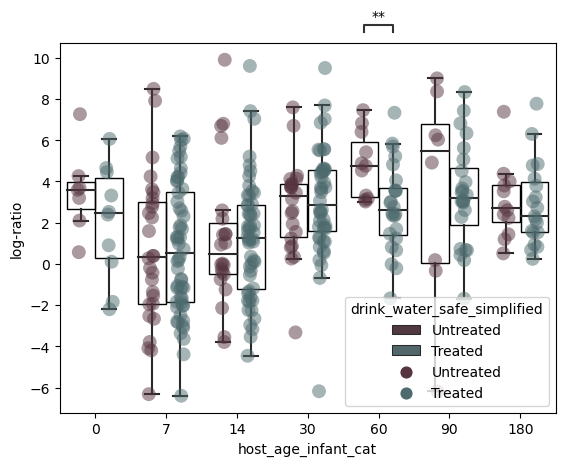

In [160]:
ax = sns.boxplot(data=agft_md, y='log-ratio', x='host_age_infant_cat', 
                 hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'], 
                 palette=['#563440', '#4D6A6D'],
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=agft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'], 
                 palette=['#563440', '#4D6A6D'],
                  size=10, alpha=0.5, dodge=True)

#pairs = [((tp,'no water treatment'), (tp, 'filtered')) for tp in agft_md['host_age_infant_cat'].unique()]
pairs = [((60,'Untreated'), (60, 'Treated'))]
annot = Annotator(ax, pairs, data=agft_md, y='log-ratio', x='host_age_infant_cat',
                   hue='drink_water_safe_simplified', hue_order=['Untreated', 'Treated'], )
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_fecal_lr_watertx_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

### fecal - water treatment

In [161]:
qval = pd.read_csv('../../data/Microbiome/ancombc2/infant_fecal_genus_ancombc2_differentials_water-binary/q.csv')
qval.drop(qval.index[0], inplace=True)
qval.rename(columns={'drink_water_safe_simplified::Treated':'q-value'}, inplace=True)
qval.head()

(Intercept)  description direction doctype  q-value extra fields index  \
1          0.0          NaN       NaN     NaN      1.0   NaN    NaN   NaN   
2          1.0          NaN       NaN     NaN      1.0   NaN    NaN   NaN   
3          1.0          NaN       NaN     NaN      1.0   NaN    NaN   NaN   
4          1.0          NaN       NaN     NaN      1.0   NaN    NaN   NaN   
5          1.0          NaN       NaN     NaN      1.0   NaN    NaN   NaN   

  style                                              taxon  title  
1   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Bac...    NaN  
2   NaN  d__Bacteria;p__Actinomycetota;c__Actinomycetes...    NaN  
3   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN  
4   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN  
5   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN

In [163]:
lfc = pd.read_csv('../../data/Microbiome/ancombc2/infant_fecal_genus_ancombc2_differentials_water-binary/lfc.csv')
lfc.drop(lfc.index[0], inplace=True)
lfc.rename(columns={'drink_water_safe_simplified::Treated':'lfc'}, inplace=True)
lfc.head()

(Intercept)  description direction doctype       lfc extra fields index  \
1    -0.505481          NaN       NaN     NaN -0.065386   NaN    NaN   NaN   
2     0.124120          NaN       NaN     NaN  0.281409   NaN    NaN   NaN   
3    -0.051314          NaN       NaN     NaN -0.011475   NaN    NaN   NaN   
4     0.277146          NaN       NaN     NaN  0.063041   NaN    NaN   NaN   
5     0.211106          NaN       NaN     NaN  0.010240   NaN    NaN   NaN   

  style                                              taxon  title  
1   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Bac...    NaN  
2   NaN  d__Bacteria;p__Actinomycetota;c__Actinomycetes...    NaN  
3   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN  
4   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN  
5   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN

In [164]:
se = pd.read_csv('../../data/Microbiome/ancombc2/infant_fecal_genus_ancombc2_differentials_water-binary/se.csv')
se.drop(se.index[0], inplace=True)
se.rename(columns={'drink_water_safe_simplified::Treated':'se'}, inplace=True)
se.head()

(Intercept)  description direction doctype        se extra fields index  \
1     0.042350          NaN       NaN     NaN  0.059410   NaN    NaN   NaN   
2     0.196455          NaN       NaN     NaN  0.234092   NaN    NaN   NaN   
3     0.086086          NaN       NaN     NaN  0.106619   NaN    NaN   NaN   
4     0.183275          NaN       NaN     NaN  0.217499   NaN    NaN   NaN   
5     0.137319          NaN       NaN     NaN  0.157690   NaN    NaN   NaN   

  style                                              taxon  title  
1   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Bac...    NaN  
2   NaN  d__Bacteria;p__Actinomycetota;c__Actinomycetes...    NaN  
3   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN  
4   NaN  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...    NaN  
5   NaN  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...    NaN

In [165]:
ifecal_water = pd.merge(qval[['taxon', 'q-value']],
               lfc[['taxon', 'lfc']],
               left_on='taxon', right_on='taxon')
ifecal_water2 = pd.merge(ifecal_water, se[['taxon', 'se']],
                  left_on='taxon', right_on='taxon')
ifecal_water2.head()

taxon  q-value       lfc  \
0  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Bac...      1.0 -0.065386   
1  d__Bacteria;p__Actinomycetota;c__Actinomycetes...      1.0  0.281409   
2  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...      1.0 -0.011475   
3  d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lac...      1.0  0.063041   
4  d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...      1.0  0.010240   

         se  
0  0.059410  
1  0.234092  
2  0.106619  
3  0.217499  
4  0.157690

In [166]:
ifecal_water2['genus'] = ifecal_water2['taxon'].str.split(";").str[-1]

In [167]:
sig_ifecal_water = ifecal_water2[(ifecal_water2['q-value']<0.05)&(abs(ifecal_water2['lfc'])>1)].copy()
sig_ifecal_water.sort_values(by='lfc')
sig_ifecal_water.shape

(18, 5)

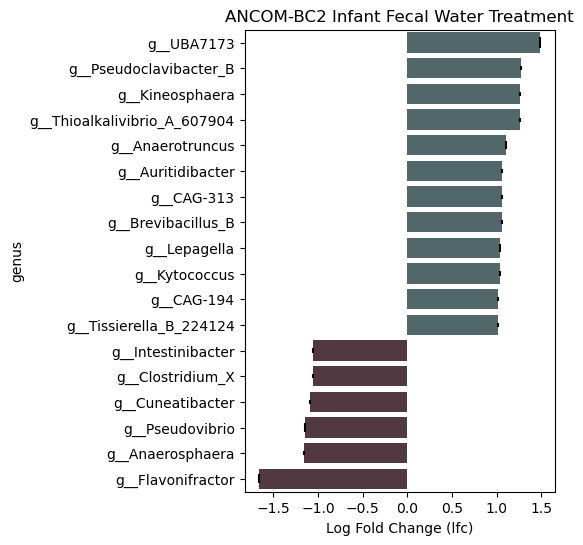

In [168]:
plt.figure(figsize=(4, 6))
sort_sig_ifecal_water = sig_ifecal_water.sort_values(by='lfc', ascending=False)
colors = ['#4D6A6D' if lfc > 0 else '#563440' for lfc in sort_sig_ifecal_water['lfc']]

sns.barplot(data=sort_sig_ifecal_water, 
            x='lfc', y='genus', yerr=sort_sig_ifecal_water['se'], 
            capsize=0.2, palette=colors)

plt.title('ANCOM-BC2 Infant Fecal Water Treatment')
plt.xlabel('Log Fold Change (lfc)')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/ancombc2_ifeces_water-safe_barplot.svg', dpi=150, bbox_inches='tight')
plt.show()

#### log ratios

In [21]:
gftable = pd.read_csv('../../data/Microbiome/ftable_infant_feces_genus/feature-table.tsv',
                     sep='\t', skiprows=1, index_col=0)
gftable.head()

14834.40249  14834.83616  \
#OTU ID                                                                        
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Baci...          0.0          0.0   
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...        659.0       2539.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          3.0          9.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        302.0       4922.0   

                                                    14834.50940  14834.51500  \
#OTU ID                                                                        
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Baci...          0.0          2.0   
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...         30.0       1987.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          1.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...         16.0         71.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        375.0       5271.0   

                                                    14834.32820  14834.33839  \
#OTU ID                                                                        
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Baci...          0.0          5.0   
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...       1271.0       1719.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          1.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...         25.0          8.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...       2450.0       2399.0   

                                                    14834.33431  14834.42203  \
#OTU ID                                                                        
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Baci...          0.0          0.0   
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...        130.0       8917.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...         12.0         20.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        262.0       5362.0   

                                                    14834.59542  14834.39547  \
#OTU ID                                                                        
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Baci...          0.0          0.0   
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...      16006.0       8398.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          2.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...       1142.0       3432.0   

                                                    ...  14834.96816  \
#OTU ID                                             ...                
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Baci...  ...          0.0   
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...  ...       6114.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...          2.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...  ...       1836.0   

                                                    14834.42694  14834.50797  \
#OTU ID                                                                        
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Baci...          0.0          0.0   
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...      11147.0       7519.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          1.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        331.0       1516.0   

                                                    14834.40608  14834.40412  \
#OTU ID                                                                        
d__Bacteria;p__Bacill

In [170]:
Numerator = sort_sig_ifecal_water[sort_sig_ifecal_water.lfc>0].taxon.values
Denominator = sort_sig_ifecal_water[sort_sig_ifecal_water.lfc<0].taxon.values

In [171]:
gftablew = gftable.T.copy()
gftablew['log-ratio'] = np.log(gftablew[Numerator].sum(axis=1)) - np.log(gftablew[Denominator].sum(axis=1))
gftablew.shape

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(385, 3563)

In [172]:
gftablew2 = gftablew[['log-ratio']].copy()
gftablew2['log-ratio'] = gftablew2['log-ratio'].replace([np.inf, -np.inf], np.nan)
gftablew2.shape

(385, 1)

In [173]:
gftablew2['log-ratio'].isnull().sum()

129

In [174]:
gftw_md = pd.merge(gftablew2, metadata, left_index=True, right_index=True)
gftw_md.shape

(385, 77)

In [175]:
ax = sns.boxplot(data=gftw_md, y='log-ratio', x='host_age_infant_cat', hue='drink_water_safe_simplified',
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1),
                palette=['#4D6A6D','#563440'])
ax = sns.stripplot(data=gftw_md, y='log-ratio', x='host_age_infant_cat', hue='drink_water_safe_simplified',
                  size=10, alpha=0.5, palette=['#4D6A6D','#563440'], dodge=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

pairs = [((tp, 'Untreated'), (tp, 'Treated')) for tp in gft_md['host_age_infant_cat'].unique()]
#pairs = [(0, tp) for tp in gft_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=gftw_md, y='log-ratio', x='host_age_infant_cat',
                 hue='drink_water_safe_simplified',)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()


plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/infant_fecal_lr_water_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

7_Treated vs. 7_Untreated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.426e-02 (ns) U_stat=4.660e+02
0_Treated vs. 0_Untreated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.436e-01 U_stat=1.650e+02
14_Treated vs. 14_Untreated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.703e-05 U_stat=4.115e+02
90_Treated vs. 90_Untreated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.118e-01 U_stat=1.260e+02
180_Treated vs. 180_Untreated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.353e-01 U_stat=7.900e+01
30_Treated vs. 30_Untreated: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.496e-02 (ns) U_stat=2.900e+02
60_Treat

In [176]:
g = sns.regplot(data=gftw_md, y='log-ratio', x='host_age_infant', 
                color='#008080', lowess=True, line_kws=dict(color="k"),)

In [177]:
g = sns.lineplot(data=gftw_md, y='log-ratio', x='host_age_infant_cat', 
                  hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_water_lineplot.svg', dpi=150, bbox_inches='tight')

In [178]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=gftw_md, y='log-ratio', x='host_age_infant_cat',
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'])
g = sns.scatterplot(data=gftw_md, y='log-ratio', x='host_age_infant', 
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

In [179]:
data = gftw_md[gftw_md['host_age_infant']<60].copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant*drink_water_safe_simplified", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
===================================================================================================
Model:                            MixedLM               Dependent Variable:               log_ratio
No. Observations:                 181                   Method:                           REML     
No. Groups:                       55                    Scale:                            6.8470   
Min. group size:                  1                     Log-Likelihood:                   -461.3675
Max. group size:                  6                     Converged:                        Yes      
Mean group size:                  3.3                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                                                -0.139    0.528 -0.264 0.792 -1.175  0.896
drink_water_safe_simplified[T.Untreated]                 -2.174    0.895 -2.430 0.015 -3.927 -0.420
host_age_infant                                           0.052    0.023  2.279 0.023  0.007  0.097
host_age_infant:drink_water_safe_simplified[T.Untreated] -0.058    0.038 -1.518 0.129 -0.133  0.017
host_subject_id Var                                       3.798    0.561                           
===================================================================================================

"""

In [180]:
gftx = gftw_md[gftw_md['host_age_infant']<=60].copy()
gftxt = gftx[gftx['drink_water_safe_simplified']=='Untreated'].copy()
gftxt['log-ratio'].mean()

-2.763770388199425

In [181]:
gftx = gftw_md[gftw_md['host_age_infant']<=60].copy()
gftxt = gftx[gftx['drink_water_safe_simplified']=='Treated'].copy()
gftxt['log-ratio'].mean()

0.5218541895138331

#### apply to adult samples

In [182]:
agftable = pd.read_csv('../../data/Microbiome/ftable_adult_feces_min10-5_genus/feature-table.tsv',
                     sep='\t', skiprows=1, index_col=0)
agftable.head()

14834.50560  14834.71261  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        127.0     172177.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...    1527463.0          0.0   

                                                    14834.39321  14834.39524  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...        564.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...      22423.0         35.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.52169  14834.32751  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...       4181.0        114.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          8.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     656063.0    1056442.0   

                                                    14834.71970  14834.50384  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...         19.0       1120.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...     134062.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.33393  14834.49749  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0       1260.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...        861.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     902950.0          0.0   

                                                    ...  14834.72944  \
#OTU ID                                             ...                
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...  ...          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...  ...          3.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...  ...          0.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...  ...      61551.0   

                                                    14834.97936  14834.44586  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...          0.0         77.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          4.0         74.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0         19.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...          0.0          0.0   

                                                    14834.23734  14834.39826  \
#OTU ID                                                                        
d__Bacteria;p__Actino

In [183]:
Numerator = sort_sig_ifecal[sort_sig_ifecal.lfc>0].taxon.values
Denominator = sort_sig_ifecal[sort_sig_ifecal.lfc<0].taxon.values

In [184]:
Num = agftable2.columns[agftable2.columns.isin(Numerator)]
Denom = agftable2.columns[agftable2.columns.isin(Denominator)]

In [185]:
agftable2 = agftable.T.copy()
agftable2['log-ratio'] = np.log(agftable2[Num].sum(axis=1)) - np.log(agftable2[Denom].sum(axis=1))
agftable2.shape

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(354, 715)

In [186]:
agftable3 = agftable2[['log-ratio']].copy()
agftable3['log-ratio'] = agftable3['log-ratio'].replace([np.inf, -np.inf], np.nan)
agftable3.shape

(354, 1)

In [187]:
agftable3['log-ratio'].isnull().sum()

15

In [188]:
agft_md = pd.merge(agftable3, metadata, left_index=True, right_index=True)
agft_md.shape

(354, 77)

In [189]:
g = sns.lineplot(data=agft_md, y='log-ratio', x='host_age_infant_cat', 
                color='#B4D8D8')
g = sns.scatterplot(data=agft_md, y='log-ratio', x='host_age_infant', 
                color='#B4D8D8')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/adult_feces_lr_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

In [190]:
data = agft_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  log_ratio
No. Observations:    339      Method:              REML     
No. Groups:          55       Scale:               7.8100   
Min. group size:     4        Log-Likelihood:      -848.9346
Max. group size:     7        Converged:           Yes      
Mean group size:     6.2                                    
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           1.536    0.239 6.417 0.000  1.067  2.005
host_age_infant     0.013    0.003 4.252 0.000  0.007  0.018
host_subject_id Var 0.919    0.165                          
============================================================

"""

### Log Ratio [from paper](https://doi.org/10.3920/bm2017.0020) - Klebsiella/Bifidobacterium

In [209]:
Numerator = gftable[gftable.index.str.contains('Klebsiella')].index.values
Denominator = gftable[gftable.index.str.contains('Bifidobacterium')].index.values

In [210]:
KB_table = gftable.T.copy()
KB_table['log-ratio'] = np.log(KB_table[Numerator].sum(axis=1)) - np.log(KB_table[Denominator].sum(axis=1))
KB_table.shape

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(385, 3563)

In [211]:
KB_table3 = KB_table[['log-ratio']].copy()
KB_table3['log-ratio'] = KB_table3['log-ratio'].replace([np.inf, -np.inf], np.nan)
KB_table3.shape

(385, 1)

In [212]:
KB_table3['log-ratio'].isnull().sum()
#few NaNs, a good ratio

2

In [213]:
kb_md = pd.merge(KB_table3, metadata, left_index=True, right_index=True)
kb_md.shape

(385, 77)

In [214]:
ax = sns.boxplot(data=kb_md, y='log-ratio', x='host_age_infant_cat', 
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=kb_md, y='log-ratio', x='host_age_infant_cat',
                  size=10, alpha=0.5, color='#008080')

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [(0, tp) for tp in kb_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=kb_md, y='log-ratio', x='host_age_infant_cat')
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 0: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.000e+00 U_stat=1.404e+03
0 vs. 7: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.735e-01 U_stat=2.373e+03
0 vs. 14: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.413e-04 U_stat=2.638e+03
0 vs. 30: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.086e-07 U_stat=2.839e+03
0 vs. 60: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.576e-06 U_stat=1.265e+03
0 vs. 90: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.752e-06 U_stat=1.639e+03
0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.896e-08 U_stat=1.371e+03


In [215]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=kb_md, y='log-ratio', x='host_age_infant_cat',
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'])
g = sns.scatterplot(data=kb_md, y='log-ratio', x='host_age_infant', 
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

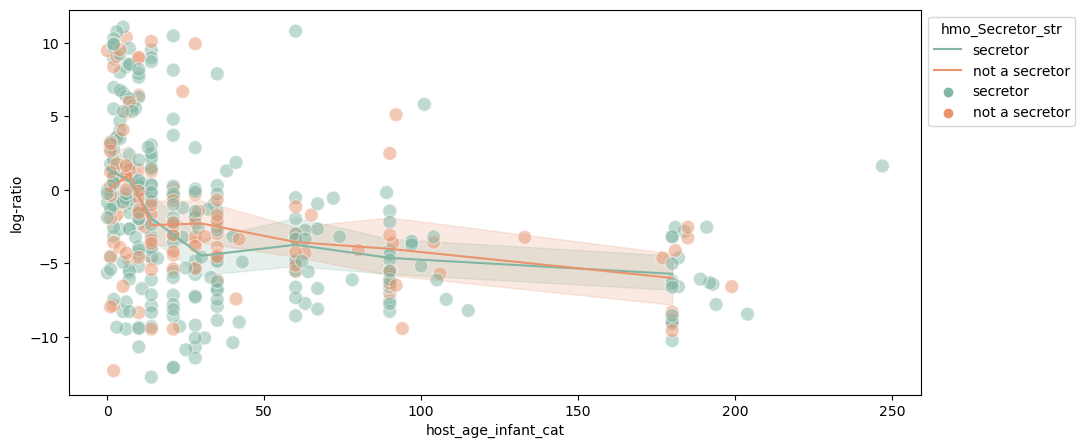

In [226]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=kb_md[kb_md['hmo_Secretor_str']!='unknown'], 
                 y='log-ratio', x='host_age_infant_cat',
                hue='hmo_Secretor_str', palette=['#80B6A3','#E9946E'])
g = sns.scatterplot(data=kb_md[kb_md['hmo_Secretor_str']!='unknown'], 
                    y='log-ratio', x='host_age_infant', 
                hue='hmo_Secretor_str', palette=['#80B6A3','#E9946E'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

# Other Log Ratio

In [216]:
gftable[gftable.index.str.contains('Gammaproteobacteria|Bifidobacterium|actobacillus')].shape

(787, 385)

In [217]:
Numerator = gftable[gftable.index.str.contains('Gammaproteobacteria')].index.values
Denominator = gftable[gftable.index.str.contains('Bifidobacterium|actobacillus')].index.values

In [218]:
gpb_bl_table = gftable.T.copy()
gpb_bl_table['log-ratio'] = np.log(gpb_bl_table[Numerator].sum(axis=1)) - np.log(gpb_bl_table[Denominator].sum(axis=1))
gpb_bl_table.shape

(385, 3563)

In [219]:
gpb_bl_table3 = gpb_bl_table[['log-ratio']].copy()
gpb_bl_table3['log-ratio'] = gpb_bl_table3['log-ratio'].replace([np.inf, -np.inf], np.nan)
gpb_bl_table3.shape

(385, 1)

In [220]:
gpb_bl_table3['log-ratio'].isnull().sum()
#no NaNs, a good ratio

0

In [221]:
gpb_bl_md = pd.merge(KB_table3, metadata, left_index=True, right_index=True)
gpb_bl_md.shape

(385, 77)

In [222]:
ax = sns.boxplot(data=gpb_bl_md, y='log-ratio', x='host_age_infant_cat', 
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=gpb_bl_md, y='log-ratio', x='host_age_infant_cat',
                  size=10, alpha=0.5, color='#008080')

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [(0, tp) for tp in gpb_bl_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=gpb_bl_md, y='log-ratio', x='host_age_infant_cat')
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 0: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.000e+00 U_stat=1.404e+03
0 vs. 7: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.735e-01 U_stat=2.373e+03
0 vs. 14: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.413e-04 U_stat=2.638e+03
0 vs. 30: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.086e-07 U_stat=2.839e+03
0 vs. 60: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.576e-06 U_stat=1.265e+03
0 vs. 90: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.752e-06 U_stat=1.639e+03
0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.896e-08 U_stat=1.371e+03


In [223]:
data = gpb_bl_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()
#trends towards lower, but not significant

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   log_ratio 
No. Observations:   383       Method:               REML      
No. Groups:         55        Scale:                19.2385   
Min. group size:    6         Log-Likelihood:       -1142.5059
Max. group size:    7         Converged:            Yes       
Mean group size:    7.0                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.498    0.422 -1.181 0.238 -1.324  0.329
host_age_infant     -0.035    0.004 -7.789 0.000 -0.044 -0.026
host_subject_id Var  5.247    0.379                           
==============================================================

"""

In [224]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=gpb_bl_md, y='log-ratio', x='host_age_infant_cat',
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'])
g = sns.scatterplot(data=gpb_bl_md, y='log-ratio', x='host_age_infant', 
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

In [225]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=gpb_bl_md, y='log-ratio', x='host_age_infant_cat',
                hue='mode_delivery', palette=['#6A66A3','#84A9C0'])
g = sns.scatterplot(data=gpb_bl_md, y='log-ratio', x='host_age_infant', 
                hue='mode_delivery', palette=['#6A66A3','#84A9C0'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

In [227]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=gpb_bl_md[gpb_bl_md['hmo_Secretor_str']!='unknown'], 
                 y='log-ratio', x='host_age_infant_cat',
                hue='hmo_Secretor_str', palette=['#80B6A3','#E9946E'])
g = sns.scatterplot(data=gpb_bl_md[gpb_bl_md['hmo_Secretor_str']!='unknown'], 
                    y='log-ratio', x='host_age_infant', 
                hue='hmo_Secretor_str', palette=['#80B6A3','#E9946E'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

### Protease bacteria [from paper](https://doi.org/10.1111/j.1365-2672.1988.tb02427.x)

In [22]:
gftable[gftable.index.str.contains('Clostridium|Streptococcus|Bacteroides|Propionibacterium')].shape

(43, 385)

In [23]:
gftable['total_reads'] = gftable.sum(axis=1)

In [24]:
gftable.sort_values(by='total_reads', ascending=False)

14834.40249  14834.83616  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...     242981.0     929008.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...      32427.0      40513.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...    1181567.0    1506432.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          3.0       2918.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...       4216.0      11652.0   
...                                                         ...          ...   
d__Bacteria;p__Bacillota_B_370525;c__Desulfotom...          0.0          0.0   
d__Bacteria;p__Desulfobacterota_G_459546;c__Des...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia...          0.0          0.0   
d__Bacteria;p__Cyanobacteriota;c__Cyanobacterii...          0.0          0.0   

                                                    14834.50940  14834.51500  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...      66176.0       1450.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...      14037.0     781539.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...       7710.0    5662371.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          0.0     316938.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...    1798314.0     207687.0   
...                                                         ...          ...   
d__Bacteria;p__Bacillota_B_370525;c__Desulfotom...          0.0          0.0   
d__Bacteria;p__Desulfobacterota_G_459546;c__Des...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia...          0.0          0.0   
d__Bacteria;p__Cyanobacteriota;c__Cyanobacterii...          0.0          0.0   

                                                    14834.32820  14834.33839  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...       4675.0       4456.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...    5006076.0    3371011.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     107436.0      43127.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...      59476.0     865103.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     116335.0      22721.0   
...                                                         ...          ...   
d__Bacteria;p__Bacillota_B_370525;c__Desulfotom...          0.0          0.0   
d__Bacteria;p__Desulfobacterota_G_459546;c__Des...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia...          0.0          0.0   
d__Bacteria;p__Cyanobacteriota;c__Cyanobacterii...          0.0          0.0   

                                                    14834.33431  14834.42203  \
#OTU ID                                                                        
d__Bacteria;p__Actinomycetota;c__Actinomycetes;...       1332.0    4563123.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     165017.0     232384.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...     967040.0    1921112.0   
d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lact...          6.0         27.0   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobac...      17213.0       6620.0   
...                                                         ...          ...   
d__Bacteria;p__Bacillota_B_370525;c__Desulfotom...          0.0          0.0   
d__Bacteria;p__Desulfobacterota_G_459546;c__Des...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia...          0.0          0.0   
d__Bacteria;p__Bacillota_A_368345;c__Clostridia..

In [25]:
gftable[gftable.index.str.contains('Clostridium|Streptococcus|Bacteroides|Propionibacterium')].index.values

array(['d__Bacteria;p__Bacillota_I;c__Bacilli_A;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;g__Clostridium_G',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;g__Clostridium_S',
       'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H_857956',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;g__Clostridium_H_221916',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;g__Clostridium_B',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;g__Clostridium_F',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;g__Clostridium_T',
       'd__Bacteria;p__Bacillot

In [26]:
Numerator = gftable[gftable.index.str.contains('Clostridium|Streptococcus|Bacteroides|Propionibacterium')].index.values
Denominator = gftable[gftable.index.str.contains('Bifidobacterium|actobacillus')].index.values

In [27]:
prot_table = gftable.T.copy()
prot_table['log-ratio'] = np.log(prot_table[Numerator].sum(axis=1)) - np.log(prot_table[Denominator].sum(axis=1))
prot_table.shape

(386, 3563)

In [28]:
prot_table3 = prot_table[['log-ratio']].copy()
prot_table3['log-ratio'] = prot_table3['log-ratio'].replace([np.inf, -np.inf], np.nan)
prot_table3.shape

(386, 1)

In [29]:
prot_table3['log-ratio'].isnull().sum()
#no NaNs, a good ratio

0

In [30]:
prot_md = pd.merge(prot_table3, metadata, left_index=True, right_index=True)
prot_md.shape

(385, 77)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 0: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.000e+00 U_stat=1.404e+03
0 vs. 7: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.531e-03 U_stat=3.032e+03
0 vs. 14: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.416e-07 U_stat=3.038e+03
0 vs. 30: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.610e-10 U_stat=3.093e+03
0 vs. 60: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.718e-07 U_stat=1.347e+03
0 vs. 90: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.190e-08 U_stat=1.734e+03
0 vs. 180: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.855e-07 U_stat=1.337e+03


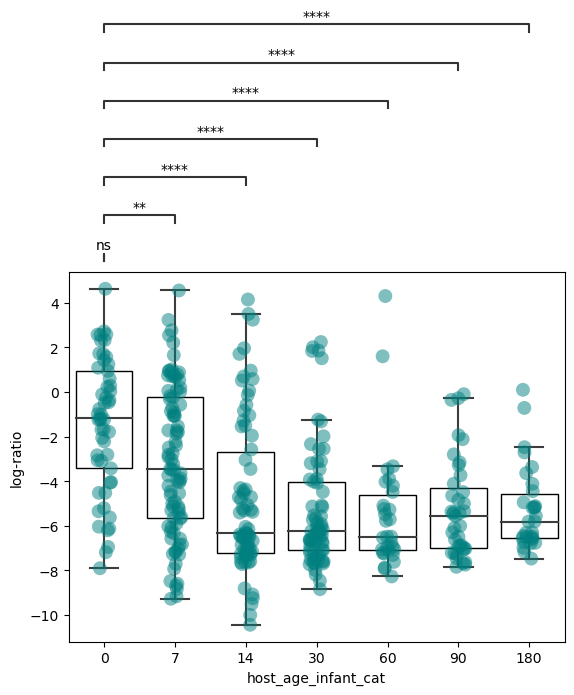

In [32]:
ax = sns.boxplot(data=prot_md, y='log-ratio', x='host_age_infant_cat', 
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1))
ax = sns.stripplot(data=prot_md, y='log-ratio', x='host_age_infant_cat',
                  size=10, alpha=0.5, color='#008080')

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [(0, tp) for tp in prot_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=prot_md, y='log-ratio', x='host_age_infant_cat')
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
data = prot_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant", data, 
                    groups="host_subject_id", re_formula='1')
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()
# significant

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   log_ratio
No. Observations:     385       Method:               REML     
No. Groups:           55        Scale:                8.2766   
Min. group size:      7         Log-Likelihood:       -982.5668
Max. group size:      7         Converged:            Yes      
Mean group size:      7.0                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           -3.607    0.259 -13.944 0.000 -4.114 -3.100
host_age_infant     -0.015    0.003  -5.059 0.000 -0.021 -0.009
host_subject_id Var  1.750    0.212                            
===============================================================

"""

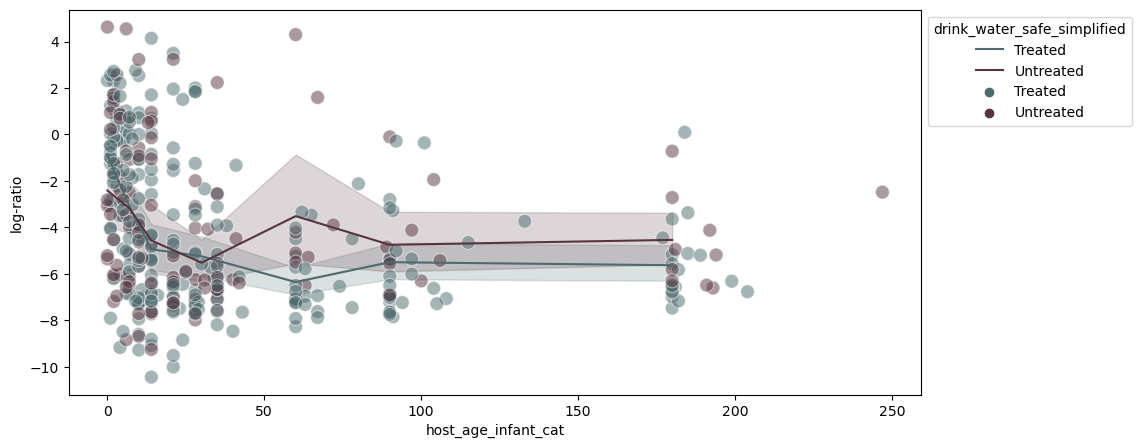

In [34]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=prot_md, y='log-ratio', x='host_age_infant_cat',
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'])
g = sns.scatterplot(data=prot_md, y='log-ratio', x='host_age_infant', 
                hue='drink_water_safe_simplified', palette=['#4D6A6D','#563440'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

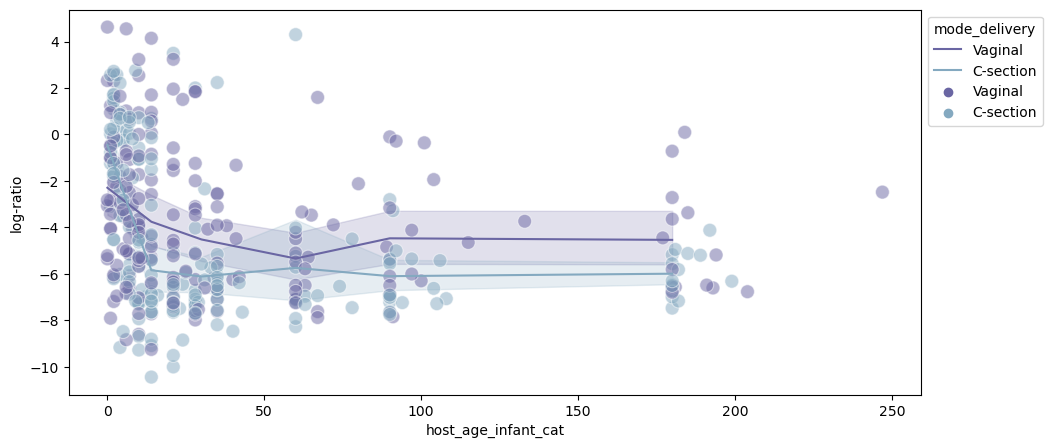

In [35]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=prot_md, y='log-ratio', x='host_age_infant_cat',
                hue='mode_delivery', palette=['#6A66A3','#84A9C0'])
g = sns.scatterplot(data=prot_md, y='log-ratio', x='host_age_infant', 
                hue='mode_delivery', palette=['#6A66A3','#84A9C0'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_protease_boxplot_long.png', dpi=150, bbox_inches='tight')
plt.show()

In [37]:
data = prot_md.copy()
data.rename(columns={'log-ratio':'log_ratio'}, inplace=True)
data.dropna(subset='log_ratio', inplace=True) #need to drop nans
model = smf.mixedlm("log_ratio~host_age_infant*mode_delivery", data, 
                    groups="host_subject_id", re_formula="1")
res = model.fit(method=['lbfgs',  'powell', 'cg'])
res.summary()
#trends towards

/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                       MixedLM          Dependent Variable:          log_ratio
No. Observations:            385              Method:                      REML     
No. Groups:                  55               Scale:                       8.2504   
Min. group size:             7                Log-Likelihood:              -983.8232
Max. group size:             7                Converged:                   Yes      
Mean group size:             7.0                                                    
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                -3.873    0.362 -10.689 0.000 -4.583 -3.163
mode_delivery[T.Vaginal]                  0.530    0.507   1.044 0.296 -0.464  1.524
host_age_infant                          -0.019    0.004  -4.551 0.000 -0.027 -0.011
host_age_infant:mode_delivery[T.Vaginal]  0.008    0.006   1.440 0.150 -0.003  0.020
host_subject_id Var                       1.613    0.203                            
====================================================================================

"""

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

7_Vaginal vs. 7_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.151e-01 U_stat=1.019e+03
0_Vaginal vs. 0_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.733e-02 (ns) U_stat=2.240e+02
14_Vaginal vs. 14_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.888e-03 U_stat=9.600e+02
30_Vaginal vs. 30_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.451e-03 U_stat=8.490e+02
180_Vaginal vs. 180_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.585e-01 U_stat=1.470e+02
90_Vaginal vs. 90_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.944e-02 (ns) U_stat=2.680e+02
60_Vagin

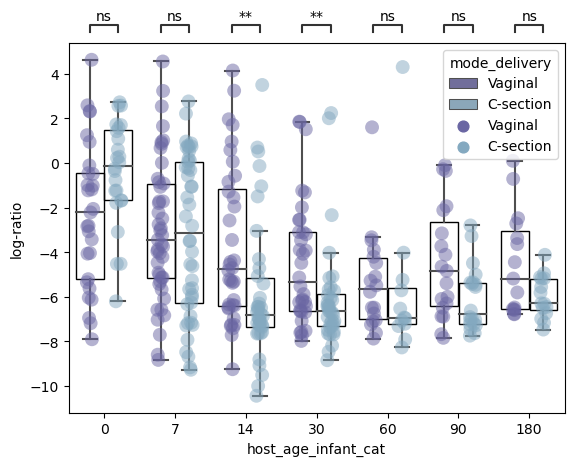

In [38]:
ax = sns.boxplot(data=prot_md, y='log-ratio', x='host_age_infant_cat',  hue='mode_delivery',
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1),
                palette=['#6A66A3','#84A9C0'])
ax = sns.stripplot(data=prot_md, y='log-ratio', x='host_age_infant_cat', hue='mode_delivery',
                  size=10, alpha=0.5, palette=['#6A66A3','#84A9C0'], dodge=True)

#pairs = [(tp[0], tp[1]) for tp in combinations(gft_md['host_age_infant_cat'].unique(), 2)]
pairs = [((tp, 'Vaginal'), (tp, 'C-section')) for tp in prot_md['host_age_infant_cat'].unique()]
annot = Annotator(ax, pairs, data=prot_md, y='log-ratio', x='host_age_infant_cat', hue='mode_delivery',)
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

older than 30 days_Vaginal vs. older than 30 days_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.854e-04 U_stat=3.123e+03
30 days of age or less_Vaginal vs. 30 days of age or less_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.032e-02 U_stat=8.749e+03


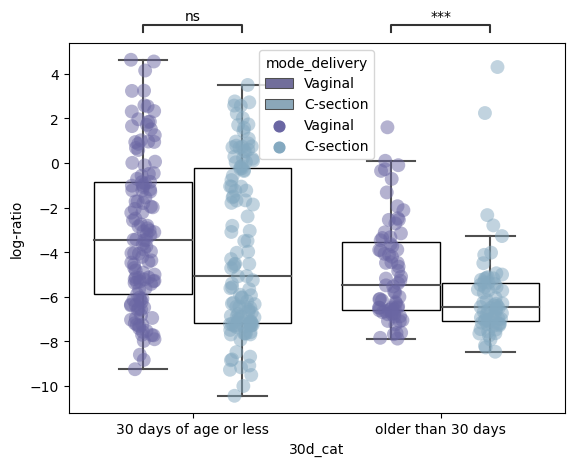

In [39]:
ax = sns.boxplot(data=prot_md, y='log-ratio', x='30d_cat',  hue='mode_delivery',
                 order=['30 days of age or less', 'older than 30 days'], 
                fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1),
                palette=['#6A66A3','#84A9C0'])
ax = sns.stripplot(data=prot_md, y='log-ratio', x='30d_cat', hue='mode_delivery',
                   order=['30 days of age or less', 'older than 30 days'],
                  size=10, alpha=0.5, palette=['#6A66A3','#84A9C0'], dodge=True)

pairs = [((tp, 'Vaginal'), (tp, 'C-section')) for tp in prot_md['30d_cat'].unique()]
annot = Annotator(ax, pairs, data=prot_md, y='log-ratio', x='30d_cat', hue='mode_delivery',
                 order=['30 days of age or less', 'older than 30 days'])
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_fecal_lr_boxplot2.svg', dpi=150, bbox_inches='tight')
plt.show()

In [45]:
ax = sns.pointplot(data=prot_md, y='log-ratio', x='30d_cat',  hue='mode_delivery',
                 order=['30 days of age or less', 'older than 30 days'], 
                palette=['#6A66A3','#84A9C0'], units='family_id')
ax = sns.stripplot(data=prot_md, y='log-ratio', x='30d_cat',  hue='mode_delivery',
                 order=['30 days of age or less', 'older than 30 days'], s=10, alpha=0.5,
                palette=['#6A66A3','#84A9C0'],)

pairs = [(('30 days of age or less', mode), ('older than 30 days', mode)) for mode in prot_md['mode_delivery'].unique()]+[(('older than 30 days', 'Vaginal'), ('older than 30 days', 'C-section'))]+[(('30 days of age or less', 'Vaginal'), ('30 days of age or less', 'C-section'))]
annot = Annotator(ax, pairs, data=prot_md, y='log-ratio', x='30d_cat', hue='mode_delivery',
                 order=['30 days of age or less', 'older than 30 days'])
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_protease_pointscatterplot.svg', dpi=150, bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

older than 30 days_Vaginal vs. older than 30 days_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.854e-04 U_stat=3.123e+03
30 days of age or less_Vaginal vs. 30 days of age or less_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:6.032e-02 U_stat=8.749e+03
30 days of age or less_Vaginal vs. older than 30 days_Vaginal: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.594e-04 U_stat=5.800e+03
30 days of age or less_C-section vs. older than 30 days_C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.556e-03 U_stat=5.141e+03


/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/callaband/miniforge3/envs/plotting/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are ther

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Vaginal vs. C-section: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.107e-05 U_stat=3.262e+03


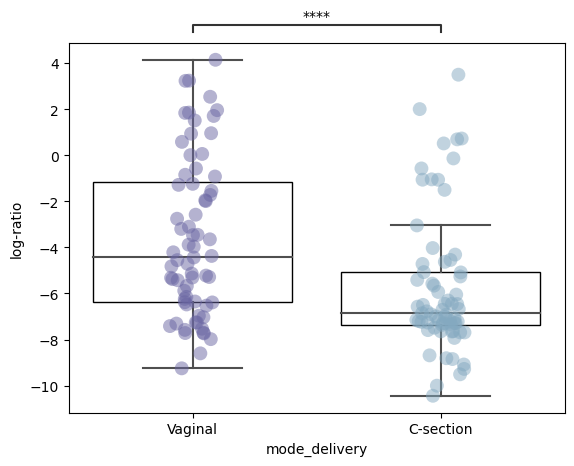

In [46]:
mmatch = prot_md[(prot_md['host_age_infant']>=10)&(prot_md['host_age_infant']<=30)].copy()
ax = sns.boxplot(data=mmatch, y='log-ratio', x='mode_delivery',
                 fliersize=0, boxprops=dict(facecolor='none', edgecolor='black', linewidth=1),
                palette=['#6A66A3','#84A9C0'], )
ax = sns.stripplot(data=mmatch, y='log-ratio', x='mode_delivery',
                s=10, alpha=0.5,
                palette=['#6A66A3','#84A9C0'],)

pairs = [('Vaginal', 'C-section')]
annot = Annotator(ax, pairs, data=mmatch, y='log-ratio', x='mode_delivery')
annot.configure(test='Mann-Whitney', comparisons_correction="holm", loc='outside', 
                    correction_format="replace", verbose=2).apply_test().annotate()

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_protease_d10-30_pointscatterplot.png', dpi=150, bbox_inches='tight')
plt.show()

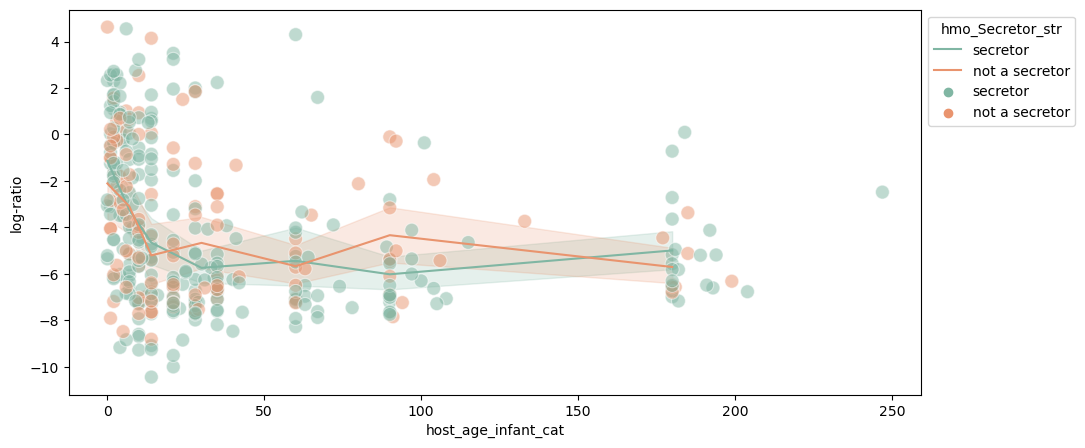

In [47]:
plt.figure(figsize=(11, 5)) 
g = sns.lineplot(data=prot_md[prot_md['hmo_Secretor_str']!='unknown'], 
                 y='log-ratio', x='host_age_infant_cat',
                hue='hmo_Secretor_str', palette=['#80B6A3','#E9946E'])
g = sns.scatterplot(data=prot_md[prot_md['hmo_Secretor_str']!='unknown'], 
                    y='log-ratio', x='host_age_infant', 
                hue='hmo_Secretor_str', palette=['#80B6A3','#E9946E'],
                   s=100, alpha=0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/infant_feces_lr_water_boxplot_long.svg', dpi=150, bbox_inches='tight')
plt.show()

# Beta Diversity

In [7]:
st2 = pd.read_csv('../data/Microbiome/SourceTracker2/iall/mixing_proportions_sinkrows-sourcescolumns.txt',
                 sep='\t')
st2.head()

SampleID  breast milk     feces  vaginal mucus   Unknown
0  14834.27393     0.028727  0.000155       0.004658  0.966460
1  14834.41764     0.000000  0.000000       0.002019  0.997981
2  14834.40446     0.001242  0.002640       0.004503  0.991615
3  14834.46962     0.034627  0.000000       0.959783  0.005590
4  14834.95284     0.000466  0.000466       0.001553  0.997516

In [8]:
st2rf = pd.melt(st2, value_vars=['breast milk', 'feces', 'vaginal mucus', 'Unknown'],
               id_vars=['SampleID'])
st2rf.set_index('SampleID', inplace=True)
st2rf.head()

variable     value
SampleID                          
14834.27393  breast milk  0.028727
14834.41764  breast milk  0.000000
14834.40446  breast milk  0.001242
14834.46962  breast milk  0.034627
14834.95284  breast milk  0.000466

In [9]:
st2_md = pd.merge(st2rf, metadata, left_index=True, right_index=True)
st2_md.head()

variable     value age_enrollment_study  collection_date  \
14834.100328    breast milk  0.000000                    0             2021   
14834.100328          feces  0.000466                    0             2021   
14834.100328  vaginal mucus  0.000000                    0             2021   
14834.100328        Unknown  0.999534                    0             2021   
14834.100334    breast milk  0.000155                    0             2021   

              collection_timestamp     country   description  dna_extracted  \
14834.100328                  2021  Bangladesh  infant stool           True   
14834.100328                  2021  Bangladesh  infant stool           True   
14834.100328                  2021  Bangladesh  infant stool           True   
14834.100328                  2021  Bangladesh  infant stool           True   
14834.100334                  2021  Bangladesh  infant stool           True   

              elevation           empo_1  ... sample_type_binary  \
14834.100328         32  Host-associated  ...             sample   
14834.100328         32  Host-associated  ...             sample   
14834.100328         32  Host-associated  ...             sample   
14834.100328         32  Host-associated  ...             sample   
14834.100334         32  Host-associated  ...             sample   

             host_age_infant_cat bf_category hmo_Secretor_str  sample_type2  \
14834.100328                 180  Partial BF         secretor  infant_feces   
14834.100328                 180  Partial BF         secretor  infant_feces   
14834.100328                 180  Partial BF         secretor  infant_feces   
14834.100328                 180  Partial BF         secretor  infant_feces   
14834.100334                 180         EBF   not a secretor  infant_feces   

                 delivery_bf-cat SourceSink plate             30d_cat  \
14834.100328  Vaginal_Partial BF       Sink   P14  older than 30 days   
14834.100328  Vaginal_Partial BF       Sink   P14  older than 30 days   
14834.100328  Vaginal_Partial BF       Sink   P14  older than 30 days   
14834.100328  Vaginal_Partial BF       Sink   P14  older than 30 days   
14834.100334  Vaginal_Partial BF       Sink   P14  older than 30 days   

                                  variability  
14834.100328  infant more variable than adult  
14834.100328  infant more variable than adult  
14834.100328  infant more variable than adult  
14834.100328  infant more variable than adult  
14834.100334  infant more variable than adult  

[5 rows x 81 columns]

In [10]:
st2_md.sample_type.unique()

array(['feces', 'skin of arm', 'tongue'], dtype=object)

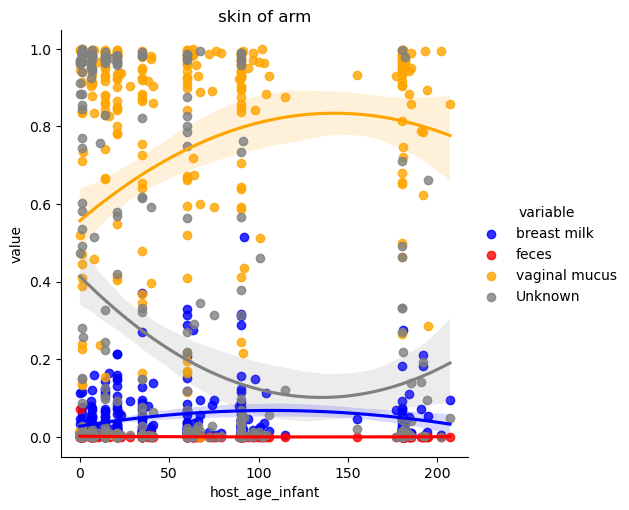

In [13]:
for x in st2_md.sample_type.unique():
    st2_df = st2_md.reset_index()
    g = sns.lmplot(data=st2_df[st2_df.sample_type==x].copy(), 
                       hue_order=['breast milk', 'feces', 'vaginal mucus', 'Unknown'],
                     x='host_age_infant', y='value', hue='variable',
                     palette=['blue', 'red', 'orange', 'grey'],
                   order=2)
    plt.title(x)
    plt.show()

## PhyloRPCA Ordination

In [49]:
phyrpca = pd.read_csv('../../data/Microbiome/lr-metrics/phyloRPCA-ordination/ordination_reformat.txt',
                     sep='\t', index_col=0)

In [50]:
prpca_md = pd.merge(phyrpca, metadata, left_index=True, right_index=True)
prpca_md.head()

Axis1_67.5  Axis2_19.4  Axis3_13.1 age_enrollment_study  \
14834.11996   -0.011061   -0.051899    0.016911                    0   
14834.20924    0.008454   -0.035572   -0.021252                    1   
14834.22843   -0.017607   -0.018453   -0.009880                    0   
14834.23020   -0.007117    0.004693   -0.011805                    1   
14834.23058   -0.013654    0.022321    0.005166                    1   

             collection_date  collection_timestamp     country  \
14834.11996             2021                  2021  Bangladesh   
14834.20924             2021                  2021  Bangladesh   
14834.22843             2021                  2021  Bangladesh   
14834.23020             2021                  2021  Bangladesh   
14834.23058             2021                  2021  Bangladesh   

                description  dna_extracted  elevation  ... hmo_Secretor  \
14834.11996    infant stool           True         32  ...            0   
14834.20924    infant stool           True         32  ...            1   
14834.22843    infant stool           True         32  ...            0   
14834.23020  maternal stool           True         32  ...            1   
14834.23058  maternal stool           True         32  ...            1   

            drink_water_safe drink_water_safe_simplified sample_type_binary  \
14834.11996      boil_strain                     Treated             sample   
14834.20924      boil_filter                     Treated             sample   
14834.22843          nothing                   Untreated             sample   
14834.23020          nothing                   Untreated             sample   
14834.23058          nothing                   Untreated             sample   

            host_age_infant_cat hmo_Secretor_str  sample_type2  \
14834.11996                  30   not a secretor  infant_feces   
14834.20924                   0         secretor  infant_feces   
14834.22843                   0   not a secretor  infant_feces   
14834.23020                   7         secretor   adult_feces   
14834.23058                   7         secretor   adult_feces   

                    delivery_bf-cat SourceSink                 30d_cat  
14834.11996      Vaginal_Partial BF       Sink  30 days of age or less  
14834.20924  Vaginal_Predominant BF       Sink  30 days of age or less  
14834.22843             Vaginal_EBF       Sink  30 days of age or less  
14834.23020           C-section_nan     Source  30 days of age or less  
14834.23058           C-section_nan     Source  30 days of age or less  

[5 rows x 79 columns]

In [51]:
prpca_md['sample_type2'].unique()

array(['infant_feces', 'adult_feces', 'adult_breast milk',
       'adult_vaginal mucus', 'infant_skin of arm', 'infant_tongue'],
      dtype=object)

In [52]:
sns.scatterplot(data=prpca_md, x='host_age_infant', y='Axis1_67.5', 
             hue='sample_type2', 
             hue_order=['infant_feces', 'adult_feces', 'adult_breast milk',
       'adult_vaginal mucus', 'infant_skin of arm', 'infant_tongue'],
             palette=['#008080', '#B4D8D8', '#BE98C7', '#F69320', '#3D793B', '#6851A2'],)
plt.show()

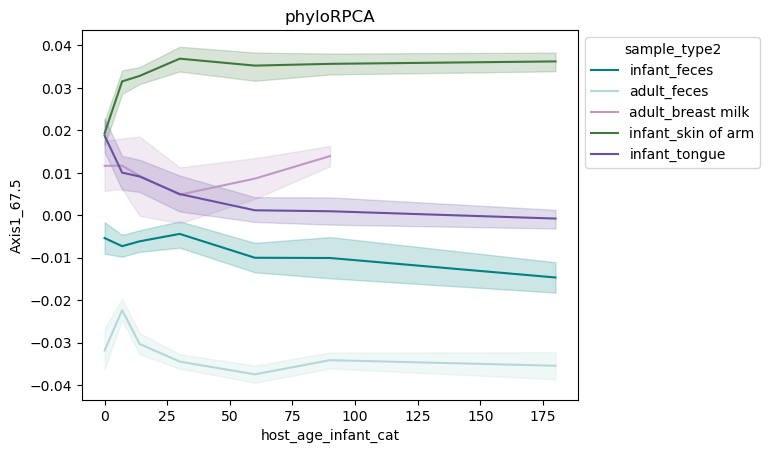

In [53]:
ax = sns.lineplot(data=prpca_md[prpca_md['sample_type2']!='adult_vaginal mucus'], 
                  x='host_age_infant_cat', y='Axis1_67.5', 
             hue='sample_type2', 
             hue_order=['infant_feces', 'adult_feces', 'adult_breast milk',
        'infant_skin of arm', 'infant_tongue'],
             palette=['#008080', '#B4D8D8', '#BE98C7', '#3D793B', '#6851A2'],
            ci=95)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('phyloRPCA')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../figures/phyloRPCA_timepoints.svg', dpi=150, bbox_inches='tight')
plt.show()

### phyloRPCA Bsig Body Site

In [56]:
stats = pd.read_csv('../../data/Microbiome/lr-metrics/phyloRPCA_sampletype2_bsig.csv')
stats.head()

Group 1        Group 2  Sample size  Permutations    pseudo-F  \
0  adult_breast milk    adult_feces          467           999  116.273640   
1  adult_breast milk  adult_vaginal          124           999    6.583908   
2  adult_breast milk   infant_feces          462           999   76.468153   
3  adult_breast milk    infant_skin          433           999   73.671330   
4  adult_breast milk  infant_tongue          431           999   16.967158   

   p-value   q-value  
0    0.001  0.001154  
1    0.004  0.004000  
2    0.001  0.001154  
3    0.001  0.001154  
4    0.001  0.001154

In [57]:
stats[['g1_ls', 'g1_site']] = stats['Group 1'].str.split("_", expand=True)
stats[['g2_ls', 'g2_site']] = stats['Group 2'].str.split("_", expand=True)

In [58]:
stats.head()

Group 1        Group 2  Sample size  Permutations    pseudo-F  \
0  adult_breast milk    adult_feces          467           999  116.273640   
1  adult_breast milk  adult_vaginal          124           999    6.583908   
2  adult_breast milk   infant_feces          462           999   76.468153   
3  adult_breast milk    infant_skin          433           999   73.671330   
4  adult_breast milk  infant_tongue          431           999   16.967158   

   p-value   q-value  g1_ls      g1_site   g2_ls  g2_site  
0    0.001  0.001154  adult  breast milk   adult    feces  
1    0.004  0.004000  adult  breast milk   adult  vaginal  
2    0.001  0.001154  adult  breast milk  infant    feces  
3    0.001  0.001154  adult  breast milk  infant     skin  
4    0.001  0.001154  adult  breast milk  infant   tongue

In [59]:
stats['pair'] = stats['Group 1'].astype(str)+";"+stats['Group 2'].astype(str)

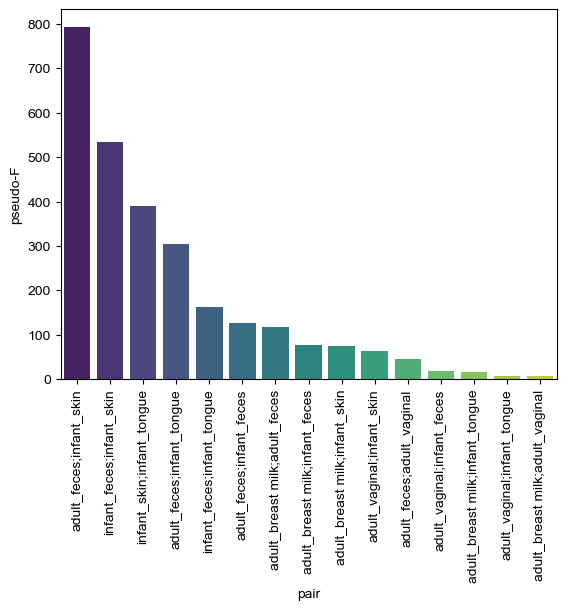

In [60]:
sns.barplot(data=stats.sort_values(by='pseudo-F', ascending=False), 
            x='pair', y='pseudo-F', palette='viridis')
plt.xticks(rotation=90)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('../figures/phyloRPCA_site_bsig_barplot.svg', dpi=300, bbox_inches="tight")